# SERIMATS Application


|           |                |
| : ----- : | :------------: |
| Candidate | Matthieu David |
| stream    | developmental interpretability |
| subject   | [task variability](https://devinterp.com/projects/task-variability) |



This notebook is inspired from the notebook [RLCT Estimation of MNIST](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/mnist.ipynb) with large change to fit my submission.


---
## RLCT Estimation of MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]()

This Jupyter Notebook aims to reproduce the results of Lau et al. (2023) by measuring the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained on the MNIST dataset. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

---

## Table of Contents:
* packages installation
* Import for the all notebook
* Method definitions
* Experiments 1 (XP1): Impact of the number of classes
    * Toy model and Resnet18 instances
    * Settings and runs label sets $Card(\mathcal{L}abels) = 2$
    * Settings and runs label sets $Card(\mathcal{L}abels) = 3$
    * Settings and runs label sets $Card(\mathcal{L}abels) = 4$
    * Settings and runs label sets $Card(\mathcal{L}abels) = 5$
    * Settings and runs label sets $Card(\mathcal{L}abels) = 6$
    * Settings and runs label sets $Card(\mathcal{L}abels) = 10$
* Displays $λ\ vs\ \mathcal{L}abels$
* Experiments 2 (XP2): Impact of the data diversity
* Experiments 3 (XP3): Impact of the number of classes

---

## Package installation:

In [1]:
%pip install devinterp matplotlib seaborn torchvision

## Import for all the notebook

In [2]:
import copy
import os
from typing import Literal

import matplotlib.pyplot as plt
import pandas as pd
from pydantic.types import confloat, conint
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from torchvision import datasets, transforms
from torchvision.models import resnet18

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt import estimate_learning_coeff

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]
sns.set_theme("paper")

## Method definitions

#### Class of the Toy model:
The toy model corresponds to the initial model used in the notebook RLCT Estimation of MNIST (rewrite a little for lisibility). This model is made of 2 linear layers, each activations being a ReLU function:

In [3]:

# Define the toy neural network
class OriginalToyNet(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(OriginalToyNet, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

# Define the toy neural network
class ToyNet(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        with_bias=True,
    ):
        super(ToyNet, self).__init__()
        self.input_dim = input_dim
        self.with_bias = with_bias
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]

        # First basic block = Linear + ReLU activation
        self.fc_1 = nn.Linear(in_features=input_dim, out_features=1024, bias=self.with_bias)
        self.relu_1 = nn.ReLU()

        # 2nd basic block = Linear + ReLU activation
        self.fc_2 = nn.Linear(in_features=1024, out_features=1024, bias=self.with_bias)
        self.relu_2 = nn.ReLU()

        # Last Fully Connected layer:
        self.fc_3 = nn.Linear(in_features=1024, out_features=output_dim, bias=self.with_bias)



    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.fc_1(x)
        x = self.relu_1(x)
        x = self.fc_2(x)
        x = self.relu_2(x)
        x = self.relu_2(x)

        x = self.fc_3(x)
        return x

In [4]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    "Original train_one_epoch method from MNIST notebook of timaeus/devinterp"
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    "Original evaluate method from MNIST notebook of timaeus/devinterp"
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


def train_step(model, optimizer, criterion, train_set):
    model.train()
    # model.to(DEVICE)

    train_loss, train_acc = 0.0, 0.0
    i = 0
    prog_bar = tqdm(train_set, desc=f"\ttrain_loss: {train_loss:0.2f} -- train_acc: {train_acc:0.2f} %")
    for x, y in prog_bar:
        # Stating variables
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad() # Clear gradients
        output = model(x) # Forward step
        loss = criterion(output, y) # Loss step

        # Backward step
        loss.backward()
        optimizer.step()

        # Accuracy
        top_p, prediction = output.topk(1, dim=1)
        equals = (prediction == y.view(*prediction.shape))

        prog_bar.set_description(f"\ttrain_loss: {train_loss / len(train_set) :0.5f} -- train_acc: {100 * train_acc / len(train_set) :0.2f} %")
        # Saving data
        train_loss += loss.item()
        train_acc += torch.mean(equals.type(torch.FloatTensor))

    return train_loss / len(train_set), train_acc / len(train_set)


def val_step(model, criterion, val_set):
    val_loss, val_acc = 0.0, 0.0

    model.eval()
    # model.to(DEVICE)
    with torch.no_grad():
        for i, (x, y) in enumerate(val_set):
            # Stating variables
            images = x.to(DEVICE)
            labels = y.to(DEVICE)

            output = model(images) # Forward step

            loss = criterion(output, labels) # Loss step

            # Accuracy
            top_p, prediction = output.topk(1, dim=1)
            equals = (prediction == labels.view(*prediction.shape))

            # Saving data
            val_loss += loss.item()
            val_acc += torch.mean(equals.type(torch.FloatTensor))

    return val_loss / len(val_set), val_acc / len(val_set)

def print_step_report(epoch:int, train_loss: float, val_loss: float, train_acc: float, val_acc: float):
    print(f"Epoch {epoch+1}:\n" \
          f"Train Loss: {train_loss:.5f}" \
          f"-- Val Loss: {val_loss:.5f}" \
          f"-- Train Acc: {train_acc:0.2f}" \
          f"-- Val Acc: {val_acc:0.2f}")

def plot_lambda_vs_epochs(train_losses, test_losses, rlct_estimates_sgnht, rlct_estimates_sgld):
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=PRIMARY)
    ax1.plot(train_losses, label="Train Loss", color=PRIMARY)
    ax1.plot(test_losses, label="Test Loss", color=PRIMARY_LIGHT)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.legend(loc="lower left")

    ax2 = ax1.twinx()
    ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
    ax2.plot(rlct_estimates_sgnht, label="SGNHT", color=SECONDARY)
    ax2.plot(rlct_estimates_sgld, label="SGLD", color=SECONDARY_LIGHT)
    ax2.tick_params(axis="y", labelcolor=SECONDARY)
    ax2.legend(loc="center right")

    fig.tight_layout()
    plt.show()

## Experiments 1 (XP1): Impact of the number of classes

This section contains all the experiments about the XP1 detailled in the application report [here](link)

First basic code cells are given the dataset MNIST and basics training with the Toy model and Resnet18 are reported. The readers can explore the core process without modifying the code for the actual experiment.

Secondly each sub experiments possess a dedicated sub section , new data loaders are generated, where the labels are rewritten to performed the experiment with the dedicated label set cardinality.

### MNIST dataset

In [5]:
# Load MNIST data
## definition of the transformation to apply to dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.244, 0.225]),
    ]
)

## Load train data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
run_toy_model = True
run_resnet = False

### Toy model and Resnet18 instances

In [ ]:
# Depending of the run type, cuda or cpu mode is defined
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------------------------------
N_CLASSES = 10 # for the 10 class digits of MNIST
lr = 0.005
n_epochs = 20
# --------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    model_resnet18 = resnet18(weights=None).to(DEVICE)

    ## changing the last fully connected layer of N neurons, each corresponding to a class.
    new_fc_act = nn.Linear(model_resnet18.fc.in_features, N_CLASSES)
    model_resnet18.fc = new_fc_act

    ## Changing the first conv2d layer to match the input image shape
    model_resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # Loss and optimizer definition
    criterion_resnet18 = nn.CrossEntropyLoss()
    optimizer_resnet18 = optim.SGD(model_resnet18.parameters(), lr=lr, momentum=0.9, nesterov=True)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_toy_model:
    # Initialize model, loss, optimizer and sgld sampler
    model_toy = ToyNet().to(DEVICE)
    criterion_toy = nn.CrossEntropyLoss()
    optimizer_toy = optim.SGD(model_toy.parameters(), lr=lr, momentum=0.9, nesterov=True)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_toy_model:
    train_losses_toy = []
    val_losses_toy = []
    models_toy = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy.append(train_loss)
        val_losses_toy.append(val_loss)
        models_toy += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy, "toy_models.pth")

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_resnet:
    train_losses_resnet = []
    val_losses_resnet = []
    models_resnet = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet.append(train_loss)
        val_losses_resnet.append(val_loss)
        models_resnet += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet, "resnet_models.pth")

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_toy_model:
    rlct_estimates_sgnht = []
    rlct_estimates_sgld = []
    for model in models_toy:
        rlct_estimate_sgnht = estimate_learning_coeff(
            model,
            train_loader,
            criterion=criterion_toy,
            optimizer_kwargs=dict(
                lr=1e-7,
                diffusion_factor=0.01,
                num_samples=len(train_data),
            ),
            sampling_method=SGNHT,
            num_chains=1,
            num_draws=400,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
        )
        rlct_estimate_sgld = estimate_learning_coeff(
            model,
            train_loader,
            criterion=criterion_toy,
            optimizer_kwargs=dict(
                lr=1e-5,
                noise_level=1.0,
                elasticity=100.0,
                num_samples=len(train_data),
                temperature="adaptive",
            ),
            sampling_method=SGLD,
            num_chains=1,
            num_draws=400,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
        )
        rlct_estimates_sgnht += [rlct_estimate_sgnht]
        rlct_estimates_sgld += [rlct_estimate_sgld]
        print(rlct_estimate_sgld, rlct_estimate_sgnht)

    # plotting
    plot_lambda_vs_epochs(train_losses_toy, val_losses_toy, rlct_estimates_sgnht, rlct_estimates_sgld)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ______________________    Resnet18 models    ______________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_resnet:
    rlct_estimates_sgnht = []
    rlct_estimates_sgld = []
    for model in models_resnet:
        rlct_estimate_sgnht = estimate_learning_coeff(
            model,
            train_loader,
            criterion=criterion_resnet18,
            optimizer_kwargs=dict(
                lr=1e-7,
                diffusion_factor=0.01,
                num_samples=len(train_data),
            ),
            sampling_method=SGNHT,
            num_chains=1,
            num_draws=400,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
        )
        rlct_estimate_sgld = estimate_learning_coeff(
            model,
            train_loader,
            criterion=criterion_resnet18,
            optimizer_kwargs=dict(
                lr=1e-5,
                noise_level=1.0,
                elasticity=100.0,
                num_samples=len(train_data),
                temperature="adaptive",
            ),
            sampling_method=SGLD,
            num_chains=1,
            num_draws=400,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
        )
        rlct_estimates_sgnht += [rlct_estimate_sgnht]
        rlct_estimates_sgld += [rlct_estimate_sgld]
        print(rlct_estimate_sgld, rlct_estimate_sgnht)

    # plotting
    plot_lambda_vs_epochs(train_losses_resnet, val_losses_resnet, rlct_estimates_sgnht, rlct_estimates_sgld)

### Settings and runs label sets $Card(\mathcal{L}abels)=2$

The different sets of labels to explore are: $\{1, other\}$ ; $\{2, other\}$ ; $\{4, other\}$ ; $\{5, other\}$ ; $\{9, other\}$.
`other` cannot be put as a label as it, it needs to be encoded into a integer. In order to relabel as we wish, we simply map the first label/digit of the sets to `1` and all the other to `0`. For example for the set $\{4,other\}$ it means that the images representing `4` will be relabeled as `1` and the images representing any of $[0, 1, 2, 3, 5, 6, 7, 8, 9]$ will be relabeled as `0`.

* labels modification and data loader
* Run for the toy model
* Run for the resnet18 model

In [7]:
# preparing the output directories of XP1
dirs = ["XP1",
        "XP1/card_2-case_1", "XP1/card_2-case_2","XP1/card_2-case_3", "XP1/card_2-case_4", "XP1/card_2-case_5",
        "XP1/card_3-case_1", "XP1/card_3-case_2","XP1/card_3-case_3", "XP1/card_3-case_4", "XP1/card_3-case_5",
        "XP1/card_4-case_1", "XP1/card_4-case_2","XP1/card_4-case_3", "XP1/card_4-case_4", "XP1/card_4-case_5",
        "XP1/card_5-case_1", "XP1/card_5-case_2","XP1/card_5-case_3", "XP1/card_5-case_4", "XP1/card_5-case_5",
        "XP1/card_10-case_1", "XP1/card_10-case_2","XP1/card_10-case_3", "XP1/card_10-case_4", "XP1/card_10-case_5"]

for path in dirs:
        os.mkdir(path)

FileExistsError: ignored

In [8]:
def load_and_process_data(bs: int, mapping_label_to_encode: dict) -> tuple[DataLoader, DataLoader]:
    """ Loads MNIST dataset, relabel the images of train and test sets

    Function load MNIST dataset and performs the relabelling. The loading performs the transformation
    necessary to normalize the data distribution.
    Before forging the data loaders, the operation of relabelling to execute the experiments
    is performed.
    Arguments:
        bs: batch size, excepting a positive integer
        mapping_label_to_encode: mapping between original labels and target labels

    Returns:
        train_loader, test_loader: data loader of train and test
    """
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    # Load train data
    train_data = datasets.MNIST("../data", train=True, transform=transform, download=True)
    for old_label, new_label in mapping_label_to_encode.items():
        train_data.targets[train_data.targets == old_label] = new_label
    print("set of labels in train data: ", train_data.targets.unique())
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Load test data
    test_data = datasets.MNIST("../data", train=False, transform=transform)
    for old_label, new_label in mapping_label_to_encode.items():
        test_data.targets[test_data.targets == old_label] = new_label
    print("set of labels in test data: ", test_data.targets.unique())
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def models_factory(model_type: Literal["toy_model", "resnet18"],
                   optim_cfg: dict,
                   optim_name: Literal['SGD'] = "SGD",
                   criterion_name: Literal["CrossEntropyLoss"]="CrossEntropyLoss",
                   lr: confloat(gt=0, lt=1)=0.005,
                   n_epochs: conint(gt=0)=20,
                   nb_classes: conint(ge=2, le=10)=10
                   ):
    """Very light factory to handle the model instanciation.

    The main purpose of this method is to centralize the models instance
    allowing lighter code cells in the following.

    Note:
        versatility is very limited here, but the idea is to use a common interface to
        generate a model withing a collection of possibility

    Args:
        model_type: name of the model to return
        optim_name: optimiser name of the model
        optim_cfg: configuration of the optimiser
        criterion_name: Loss function associated with the model for training.
            Defaults to "CrossEntropyLoss".
        lr: learning rate. Defaults to 0.005.
        n_epochs: number of epochs. Defaults to 20.
        nb_classes: number of classes of the task.
    """
    if model_type == "toy_model":
        model = ToyNet(output_dim=nb_classes).to(DEVICE)
    elif model_type == "resnet18":
        model = resnet18(weights=None).to(DEVICE)

        ## changing the last fully connected layer of N neurons, each corresponding to a class.
        new_fc_act = nn.Linear(model.fc.in_features, nb_classes)
        model.fc = new_fc_act

        ## Changing the first conv2d layer to match the input image shape
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    else:
        raise ValueError(f"Model factory does not handle model_type: '{model_type}'")

    # Loss definition
    if criterion_name == "CrossEntropyLoss":
        criterion = nn.CrossEntropyLoss()
    else:
        ValueError("Model factory only handles Cross Entropy Loss.")

    # Optimizer definition
    if optim_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, **optim_cfg)
    else:
        ValueError("Model factory only handles Cross Entropy Loss.")

    return model, optimizer, criterion


def export_loss_acc_to_csv(path: str, train_loss: list[float], test_loss: list[float], train_acc: list[float], test_acc: list[float]):
    """Save losses and accuracy into csv

    Args:
        path: path to file to save the data
        train_loss: list of the train loss along epochs
        test_loss: list of the test loss along epochs
        train_acc: list of the train accuracy along epochs
        test_acc: list of the test accuracy along epochs
    """
    df = pd.DataFrame().from_dict({"train_loss": train_loss,
                                   "test_loss": test_loss,
                                   "train_accuracy": train_acc,
                                   "test_accuracy": test_acc})
    df.to_csv(path)

def export_rlct_to_csv(path: str, rlct_estimates_sgnht: list[float], rlct_estimates_sgld: list[float]):
    """Save losses and accuracy into csv

    Args:
        path: path to file to save the data
        rlct_estimates_sgnht: list of rlct estimated with Stochastic Gradient Nose-Hoover Thermostat
        rlct_estimates_sgld: list of rlct estimated with Stochastic Gradient Langevin Dynamics
    """
    df = pd.DataFrame().from_dict({"rlct_estimates_sgnht": rlct_estimates_sgnht,
                                   "rlct_estimates_sgld": rlct_estimates_sgld})
    df.to_csv(path)

In [9]:
# keys are the original label, values are the new labels
map_label_card_2_1 = {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_2_2 = {1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_2_3 = {1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_2_4 = {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_2_5 = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1}

##### 1.1 XP1 - labels set $\mathcal{Card} = 2$ - $\mathcal{L}abels=\{1, other\}$

In [13]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## definition of the transformation to apply to dataset


## Load train data
batch_size = 512

train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_2_1)

# ------------------------------------------------------
n_classes = 2
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# ------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1])
set of labels in test data:  tensor([0, 1])


In [14]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_resnet:
    train_losses_resnet_xp1_1 = []
    val_losses_resnet_xp1_1 = []
    train_acc_resnet_xp1_1 = []
    val_acc_resnet_xp1_1 = []
    models_resnet_xp1_1 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_1.append(train_loss)
        val_losses_resnet_xp1_1.append(val_loss)
        train_acc_resnet_xp1_1.append(train_acc)
        val_acc_resnet_xp1_1.append(val_acc)
        models_resnet_xp1_1 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_1, "XP1/card_2-case_1/resnet_models.pth")
    export_loss_acc_to_csv(path="XP1/card_2-case_1/resnet_loss_acc.csv",
                       train_loss=train_losses_resnet_xp1_1,
                       test_loss=val_losses_resnet_xp1_1,
                       train_acc=train_acc_resnet_xp1_1,
                       test_acc=val_acc_resnet_xp1_1)


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_1 = []
    val_losses_toy_xp1_1 = []
    train_acc_toy_xp1_1 = []
    val_acc_toy_xp1_1 = []
    models_toy_xp1_1 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_1.append(train_loss)
        val_losses_toy_xp1_1.append(val_loss)
        train_acc_toy_xp1_1.append(train_acc)
        val_acc_toy_xp1_1.append(val_acc)
        models_toy_xp1_1 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_1, "XP1/card_2-case_1/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_2-case_1/toy_loss_acc.csv",
                       train_loss=train_losses_toy_xp1_1,
                       test_loss=val_losses_toy_xp1_1,
                       train_acc=train_acc_toy_xp1_1,
                       test_acc=val_acc_toy_xp1_1)

	train_loss: 0.11066 -- train_acc: 95.47 %: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]


Epoch 1:
Train Loss: 0.11085-- Val Loss: 0.03293-- Train Acc: 0.96-- Val Acc: 0.99


	train_loss: 0.03373 -- train_acc: 98.20 %: 100%|██████████| 118/118 [00:15<00:00,  7.73it/s]


Epoch 2:
Train Loss: 0.03388-- Val Loss: 0.02415-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02772 -- train_acc: 98.35 %: 100%|██████████| 118/118 [00:25<00:00,  4.61it/s]


Epoch 3:
Train Loss: 0.02776-- Val Loss: 0.02044-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02413 -- train_acc: 98.49 %: 100%|██████████| 118/118 [00:16<00:00,  7.16it/s]


Epoch 4:
Train Loss: 0.02430-- Val Loss: 0.01798-- Train Acc: 0.99-- Val Acc: 1.00


	train_loss: 0.02153 -- train_acc: 98.55 %: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


Epoch 5:
Train Loss: 0.02168-- Val Loss: 0.01645-- Train Acc: 0.99-- Val Acc: 1.00


	train_loss: 0.01937 -- train_acc: 98.62 %: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Epoch 6:
Train Loss: 0.01957-- Val Loss: 0.01480-- Train Acc: 0.99-- Val Acc: 1.00


	train_loss: 0.01757 -- train_acc: 98.67 %: 100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


Epoch 7:
Train Loss: 0.01774-- Val Loss: 0.01380-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01603 -- train_acc: 98.70 %: 100%|██████████| 118/118 [00:17<00:00,  6.73it/s]


Epoch 8:
Train Loss: 0.01607-- Val Loss: 0.01294-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01467 -- train_acc: 98.74 %: 100%|██████████| 118/118 [00:18<00:00,  6.26it/s]


Epoch 9:
Train Loss: 0.01480-- Val Loss: 0.01219-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01352 -- train_acc: 98.76 %: 100%|██████████| 118/118 [00:17<00:00,  6.69it/s]


Epoch 10:
Train Loss: 0.01355-- Val Loss: 0.01177-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01257 -- train_acc: 98.77 %: 100%|██████████| 118/118 [00:24<00:00,  4.77it/s]


Epoch 11:
Train Loss: 0.01263-- Val Loss: 0.01122-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01168 -- train_acc: 98.80 %: 100%|██████████| 118/118 [00:31<00:00,  3.73it/s]


Epoch 12:
Train Loss: 0.01172-- Val Loss: 0.01065-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01094 -- train_acc: 98.82 %: 100%|██████████| 118/118 [00:27<00:00,  4.34it/s]


Epoch 13:
Train Loss: 0.01099-- Val Loss: 0.01021-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01018 -- train_acc: 98.86 %: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Epoch 14:
Train Loss: 0.01030-- Val Loss: 0.00995-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00960 -- train_acc: 98.85 %: 100%|██████████| 118/118 [00:16<00:00,  6.96it/s]


Epoch 15:
Train Loss: 0.00968-- Val Loss: 0.00964-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00905 -- train_acc: 98.89 %: 100%|██████████| 118/118 [00:15<00:00,  7.39it/s]


Epoch 16:
Train Loss: 0.00914-- Val Loss: 0.00936-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00856 -- train_acc: 98.90 %: 100%|██████████| 118/118 [00:22<00:00,  5.33it/s]


Epoch 17:
Train Loss: 0.00857-- Val Loss: 0.00918-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00809 -- train_acc: 98.91 %: 100%|██████████| 118/118 [00:15<00:00,  7.70it/s]


Epoch 18:
Train Loss: 0.00812-- Val Loss: 0.00883-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00771 -- train_acc: 98.92 %: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Epoch 19:
Train Loss: 0.00772-- Val Loss: 0.00866-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00726 -- train_acc: 98.93 %: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Epoch 20:
Train Loss: 0.00744-- Val Loss: 0.00846-- Train Acc: 1.00-- Val Acc: 1.00


Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.98it/s] 


-15.988361949183192 13.683497877434009


Chain 0: 100%|██████████| 400/400 [00:24<00:00, 16.29it/s] 


-33.61987289538463 97.42390872754959


Chain 0: 100%|██████████| 400/400 [00:17<00:00, 22.30it/s] 


101.83203533212937 2.2613892193621905


Chain 0: 100%|██████████| 400/400 [00:38<00:00, 10.32it/s] 


91.13037204202749 63.009140405743295


Chain 0: 100%|██████████| 400/400 [00:35<00:00, 11.18it/s] 


116.3253493678361 134.23872281697106


Chain 0: 100%|██████████| 400/400 [00:17<00:00, 23.11it/s] 


108.17142930300487 129.65293483861154


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.00it/s] 


93.88728025701653 95.48889519738577


Chain 0: 100%|██████████| 400/400 [00:28<00:00, 13.86it/s] 


54.12910536119902 89.6787188061943


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.29it/s] 


-30.95470083990684 82.06533843236639


Chain 0: 100%|██████████| 400/400 [00:17<00:00, 22.91it/s] 


59.78944180350511 89.38113726973756


Chain 0: 100%|██████████| 400/400 [00:17<00:00, 22.45it/s] 


107.1775734474248 71.73477307693523


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.13it/s] 


69.10869353067015 45.873921330238446


Chain 0: 100%|██████████| 400/400 [00:27<00:00, 14.78it/s] 


82.3415692118926 47.586023760569354


Chain 0: 100%|██████████| 400/400 [00:20<00:00, 19.64it/s] 


78.81805951116596 37.115020211521134


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 23.62it/s] 


87.2883737825987 95.33572250499832


Chain 0: 100%|██████████| 400/400 [00:31<00:00, 12.75it/s] 


86.59442470721974 98.37832571185002


Chain 0: 100%|██████████| 400/400 [00:29<00:00, 13.52it/s] 


95.18007586768341 35.89000057772921


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.07it/s] 


61.51331876805649 107.65507310194828


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 23.74it/s] 


78.66435986434738 86.11481514148308


Chain 0: 100%|██████████| 400/400 [00:26<00:00, 15.34it/s] 


11.707881277256444 69.92981453413887


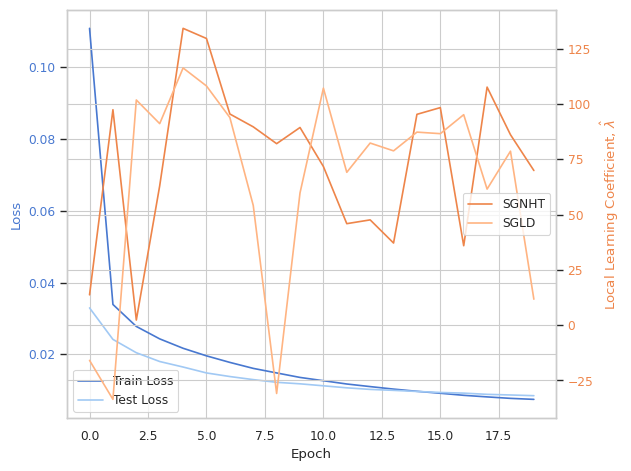

In [19]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_1:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_2-case_1/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_1, val_losses_toy_xp1_1, rlct_estimates_sgnht, rlct_estimates_sgld)


In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ______________________    Resnet18 instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_resnet_xp1_1:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_resnet,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_resnet,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_2-case_1/resnet_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_resnet_xp1_1, val_losses_resnet_xp1_1, rlct_estimates_sgnht, rlct_estimates_sgld)

##### 1.2 XP1 - labels set $\mathcal{Card} = 2$ - $\mathcal{L}abels=\{2, other\}$

In [23]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## definition of the transformation to apply to dataset


## Load train data
batch_size = 512

train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_2_2)

# ---------------------------------------------------
n_classes = 2
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# ---------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1])
set of labels in test data:  tensor([0, 1])


In [24]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_resnet:
    train_losses_resnet_xp1_2 = []
    val_losses_resnet_xp1_2 = []
    train_acc_resnet_xp1_2 = []
    val_acc_resnet_xp1_2 = []
    models_resnet_xp1_2 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_2.append(train_loss)
        val_losses_resnet_xp1_2.append(val_loss)
        models_resnet_xp1_2 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_2, "XP1/card_2-case_2/resnet_models.pth")
    export_loss_acc_to_csv(path="XP1/card_2-case_2/resnet_loss_acc.csv",
                           train_loss=train_losses_resnet_xp1_2,
                           test_loss=val_losses_resnet_xp1_2,
                           train_acc=train_acc_resnet_xp1_2,
                           test_acc=val_acc_resnet_xp1_2)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_2 = []
    val_losses_toy_xp1_2 = []
    train_acc_toy_xp1_2 = []
    val_acc_toy_xp1_2 = []
    models_toy_xp1_2 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_2.append(train_loss)
        val_losses_toy_xp1_2.append(val_loss)
        train_acc_toy_xp1_2.append(train_acc)
        val_acc_toy_xp1_2.append(val_acc)
        models_toy_xp1_2 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_2, "XP1/card_2-case_2/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_2-case_2/toy_loss_acc.csv",
                           train_loss=train_losses_toy_xp1_2,
                           test_loss=val_losses_toy_xp1_2,
                           train_acc=train_acc_toy_xp1_2,
                           test_acc=val_acc_toy_xp1_2)

	train_loss: 0.16405 -- train_acc: 93.52 %: 100%|██████████| 118/118 [00:18<00:00,  6.53it/s]


Epoch 1:
Train Loss: 0.16524-- Val Loss: 0.07966-- Train Acc: 0.94-- Val Acc: 0.98


	train_loss: 0.06701 -- train_acc: 97.08 %: 100%|██████████| 118/118 [00:15<00:00,  7.57it/s]


Epoch 2:
Train Loss: 0.06785-- Val Loss: 0.06383-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05428 -- train_acc: 97.47 %: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Epoch 3:
Train Loss: 0.05493-- Val Loss: 0.05357-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04552 -- train_acc: 97.77 %: 100%|██████████| 118/118 [00:16<00:00,  7.24it/s]


Epoch 4:
Train Loss: 0.04561-- Val Loss: 0.04688-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03893 -- train_acc: 97.98 %: 100%|██████████| 118/118 [00:15<00:00,  7.82it/s]


Epoch 5:
Train Loss: 0.03913-- Val Loss: 0.04167-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03390 -- train_acc: 98.15 %: 100%|██████████| 118/118 [00:15<00:00,  7.58it/s]


Epoch 6:
Train Loss: 0.03410-- Val Loss: 0.03686-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02985 -- train_acc: 98.30 %: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Epoch 7:
Train Loss: 0.02993-- Val Loss: 0.03321-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02656 -- train_acc: 98.39 %: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


Epoch 8:
Train Loss: 0.02664-- Val Loss: 0.03171-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02388 -- train_acc: 98.45 %: 100%|██████████| 118/118 [00:27<00:00,  4.24it/s]


Epoch 9:
Train Loss: 0.02403-- Val Loss: 0.02850-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02154 -- train_acc: 98.53 %: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


Epoch 10:
Train Loss: 0.02160-- Val Loss: 0.02751-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01969 -- train_acc: 98.57 %: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Epoch 11:
Train Loss: 0.01974-- Val Loss: 0.02516-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01791 -- train_acc: 98.62 %: 100%|██████████| 118/118 [00:31<00:00,  3.69it/s]


Epoch 12:
Train Loss: 0.01798-- Val Loss: 0.02374-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01645 -- train_acc: 98.67 %: 100%|██████████| 118/118 [00:29<00:00,  4.05it/s]


Epoch 13:
Train Loss: 0.01656-- Val Loss: 0.02279-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01515 -- train_acc: 98.72 %: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Epoch 14:
Train Loss: 0.01518-- Val Loss: 0.02209-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01393 -- train_acc: 98.76 %: 100%|██████████| 118/118 [00:15<00:00,  7.49it/s]


Epoch 15:
Train Loss: 0.01400-- Val Loss: 0.02143-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01289 -- train_acc: 98.80 %: 100%|██████████| 118/118 [00:15<00:00,  7.62it/s]


Epoch 16:
Train Loss: 0.01295-- Val Loss: 0.02063-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01179 -- train_acc: 98.84 %: 100%|██████████| 118/118 [00:15<00:00,  7.53it/s]


Epoch 17:
Train Loss: 0.01233-- Val Loss: 0.02045-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01103 -- train_acc: 98.86 %: 100%|██████████| 118/118 [00:15<00:00,  7.62it/s]


Epoch 18:
Train Loss: 0.01106-- Val Loss: 0.01988-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01026 -- train_acc: 98.89 %: 100%|██████████| 118/118 [00:16<00:00,  6.98it/s]


Epoch 19:
Train Loss: 0.01032-- Val Loss: 0.01854-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00947 -- train_acc: 98.91 %: 100%|██████████| 118/118 [00:15<00:00,  7.66it/s]


Epoch 20:
Train Loss: 0.00950-- Val Loss: 0.01822-- Train Acc: 1.00-- Val Acc: 0.99


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.58it/s] 


-3949.139021828416 -4131.328257405593


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.74it/s] 


-5920.4207031211645 -5109.65998147411


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 25.00it/s] 


-4082.069591731915 -5409.8834946968445


Chain 0: 100%|██████████| 400/400 [00:15<00:00, 25.04it/s] 


-6318.6051810235 -6091.101062635664


Chain 0: 100%|██████████| 400/400 [00:15<00:00, 25.45it/s] 


-6282.907611093289 -5359.175041458731


Chain 0: 100%|██████████| 400/400 [00:15<00:00, 25.27it/s] 


-7123.568060654356 -5742.029175166583


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.55it/s] 


-6523.726357034718 -5861.3251560655


Chain 0: 100%|██████████| 400/400 [00:19<00:00, 20.77it/s] 


-7995.407265380917 -5874.809516437012


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 23.90it/s] 


-7434.333288353511 -6102.71717003252


Chain 0: 100%|██████████| 400/400 [00:32<00:00, 12.46it/s] 


-7307.991435348425 -6780.864610824491


Chain 0: 100%|██████████| 400/400 [00:20<00:00, 19.08it/s] 


-6971.754744229578 -7953.137412213017


Chain 0: 100%|██████████| 400/400 [00:29<00:00, 13.36it/s] 


-6651.6903179614665 -6766.76353046529


Chain 0: 100%|██████████| 400/400 [00:17<00:00, 22.61it/s] 


-8218.867072169973 -6106.688787736854


Chain 0: 100%|██████████| 400/400 [00:40<00:00,  9.92it/s] 


-7607.429646336768 -6887.8439431981615


Chain 0: 100%|██████████| 400/400 [00:30<00:00, 13.02it/s] 


-8605.351667924811 -7846.961556272689


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.28it/s] 


-6885.403756342218 -9646.369920070823


Chain 0: 100%|██████████| 400/400 [00:18<00:00, 21.24it/s] 


-8028.183841383769 -7607.527861156482


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.64it/s] 


-7628.456106291723 -8666.873056820305


Chain 0: 100%|██████████| 400/400 [00:15<00:00, 25.07it/s] 


-7870.273069217676 -8868.294958208568


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.57it/s] 


-8828.109716447987 -8597.634862353012


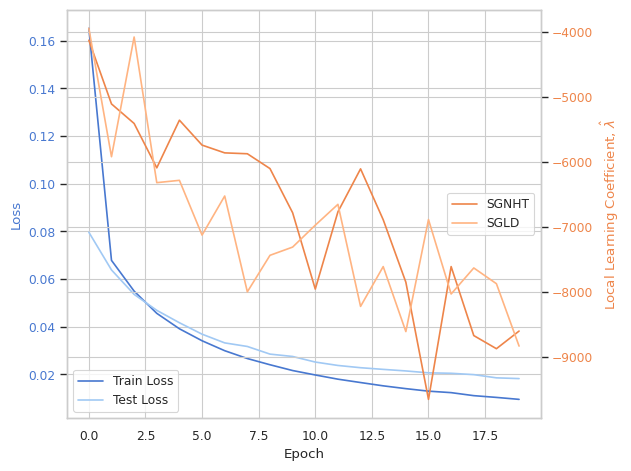

In [26]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_2:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_2-case_2/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_2, val_losses_toy_xp1_2, rlct_estimates_sgnht, rlct_estimates_sgld)


##### 1.3 XP1 - labels set $\mathcal{Card} = 2$ - $\mathcal{L}abels=\{4, other\}$

In [25]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## definition of the transformation to apply to dataset


## Load train data
batch_size = 512

train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_2_3)

# -------------------------------------------------------
n_classes = 2
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1])
set of labels in test data:  tensor([0, 1])


In [27]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_resnet:
    train_losses_resnet_xp1_3 = []
    val_losses_resnet_xp1_3 = []
    train_acc_resnet_xp1_3 = []
    val_acc_resnet_xp1_3 = []
    models_resnet_xp1_3 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_3.append(train_loss)
        val_losses_resnet_xp1_3.append(val_loss)
        train_acc_resnet_xp1_3.append(train_acc)
        val_acc_resnet_xp1_3.append(val_acc)
        models_resnet_xp1_3 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_3, "XP1/card_2-case_3/resnet_models.pth")
    export_loss_acc_to_csv(path="XP1/card_2-case_3/resnet_loss_acc.csv",
                           train_loss=train_losses_resnet_xp1_3,
                           test_loss=val_losses_resnet_xp1_3,
                           train_acc=train_acc_resnet_xp1_3,
                           test_acc=val_acc_resnet_xp1_3)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_3 = []
    val_losses_toy_xp1_3 = []
    train_acc_toy_xp1_3 = []
    val_acc_toy_xp1_3 = []
    models_toy_xp1_3 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_3.append(train_loss)
        val_losses_toy_xp1_3.append(val_loss)
        train_acc_toy_xp1_3.append(train_acc)
        val_acc_toy_xp1_3.append(val_acc)
        models_toy_xp1_3 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_3, "XP1/card_2-case_3/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_2-case_3/toy_loss_acc.csv",
                           train_loss=train_losses_toy_xp1_3,
                           test_loss=val_losses_toy_xp1_3,
                           train_acc=train_acc_toy_xp1_3,
                           test_acc=val_acc_toy_xp1_3)

	train_loss: 0.16465 -- train_acc: 93.30 %: 100%|██████████| 118/118 [00:15<00:00,  7.53it/s]


Epoch 1:
Train Loss: 0.16501-- Val Loss: 0.07328-- Train Acc: 0.94-- Val Acc: 0.98


	train_loss: 0.06014 -- train_acc: 97.26 %: 100%|██████████| 118/118 [00:15<00:00,  7.78it/s]


Epoch 2:
Train Loss: 0.06097-- Val Loss: 0.05297-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04812 -- train_acc: 97.60 %: 100%|██████████| 118/118 [00:16<00:00,  7.33it/s]


Epoch 3:
Train Loss: 0.04835-- Val Loss: 0.04628-- Train Acc: 0.98-- Val Acc: 0.99


	train_loss: 0.04115 -- train_acc: 97.87 %: 100%|██████████| 118/118 [00:16<00:00,  7.31it/s]


Epoch 4:
Train Loss: 0.04179-- Val Loss: 0.04126-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03570 -- train_acc: 98.03 %: 100%|██████████| 118/118 [00:15<00:00,  7.55it/s]


Epoch 5:
Train Loss: 0.03582-- Val Loss: 0.03660-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03111 -- train_acc: 98.20 %: 100%|██████████| 118/118 [00:15<00:00,  7.58it/s]


Epoch 6:
Train Loss: 0.03115-- Val Loss: 0.03269-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02731 -- train_acc: 98.32 %: 100%|██████████| 118/118 [00:15<00:00,  7.49it/s]


Epoch 7:
Train Loss: 0.02739-- Val Loss: 0.02903-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02404 -- train_acc: 98.45 %: 100%|██████████| 118/118 [00:15<00:00,  7.81it/s]


Epoch 8:
Train Loss: 0.02414-- Val Loss: 0.02691-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02133 -- train_acc: 98.53 %: 100%|██████████| 118/118 [00:15<00:00,  7.50it/s]


Epoch 9:
Train Loss: 0.02135-- Val Loss: 0.02458-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01909 -- train_acc: 98.59 %: 100%|██████████| 118/118 [00:15<00:00,  7.52it/s]


Epoch 10:
Train Loss: 0.01911-- Val Loss: 0.02236-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01719 -- train_acc: 98.64 %: 100%|██████████| 118/118 [00:17<00:00,  6.57it/s]


Epoch 11:
Train Loss: 0.01745-- Val Loss: 0.02083-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01553 -- train_acc: 98.70 %: 100%|██████████| 118/118 [00:15<00:00,  7.66it/s]


Epoch 12:
Train Loss: 0.01560-- Val Loss: 0.01934-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01407 -- train_acc: 98.75 %: 100%|██████████| 118/118 [00:15<00:00,  7.56it/s]


Epoch 13:
Train Loss: 0.01413-- Val Loss: 0.01811-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01280 -- train_acc: 98.79 %: 100%|██████████| 118/118 [00:15<00:00,  7.67it/s]


Epoch 14:
Train Loss: 0.01283-- Val Loss: 0.01724-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01170 -- train_acc: 98.81 %: 100%|██████████| 118/118 [00:15<00:00,  7.64it/s]


Epoch 15:
Train Loss: 0.01176-- Val Loss: 0.01685-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01068 -- train_acc: 98.84 %: 100%|██████████| 118/118 [00:15<00:00,  7.66it/s]


Epoch 16:
Train Loss: 0.01070-- Val Loss: 0.01584-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00991 -- train_acc: 98.89 %: 100%|██████████| 118/118 [00:15<00:00,  7.76it/s]


Epoch 17:
Train Loss: 0.00994-- Val Loss: 0.01529-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00903 -- train_acc: 98.91 %: 100%|██████████| 118/118 [00:15<00:00,  7.77it/s]


Epoch 18:
Train Loss: 0.00904-- Val Loss: 0.01473-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00832 -- train_acc: 98.93 %: 100%|██████████| 118/118 [00:15<00:00,  7.86it/s]


Epoch 19:
Train Loss: 0.00834-- Val Loss: 0.01464-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00765 -- train_acc: 98.96 %: 100%|██████████| 118/118 [00:17<00:00,  6.66it/s]


Epoch 20:
Train Loss: 0.00770-- Val Loss: 0.01368-- Train Acc: 1.00-- Val Acc: 0.99


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.79it/s] 


23.312131614537403 6.008684583942194


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.50it/s] 


95.50135855286761 33.07819819465662


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.51it/s] 


33.01774923768421 86.4460746064537


Chain 0: 100%|██████████| 400/400 [00:18<00:00, 21.09it/s] 


166.28826098141604 121.08519371501731


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.77it/s] 


119.89000971045866 117.45819997087608


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.20it/s] 


192.5404812478062 78.70361977646958


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.37it/s] 


163.6663207463518 83.32998937412306


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.29it/s] 


197.3201705597952 202.0150680253041


Chain 0: 100%|██████████| 400/400 [00:18<00:00, 21.30it/s] 


154.74269992467714 186.40684123555874


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.57it/s] 


335.12590360090775 182.74978016584092


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.48it/s] 


164.16887154347282 158.28162191125276


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.53it/s] 


215.07413935628398 96.00476806444284


Chain 0: 100%|██████████| 400/400 [00:19<00:00, 20.84it/s] 


185.8932157024063 200.26675557206664


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.54it/s] 


199.89451649957434 142.2831922274218


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.53it/s] 


236.26688418664094 176.36563929822742


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.36it/s] 


213.6169449876473 193.81896428111426


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.50it/s] 


256.17356018382696 187.62617677301498


Chain 0: 100%|██████████| 400/400 [00:19<00:00, 20.56it/s] 


303.39929301648976 200.7500868924505


Chain 0: 100%|██████████| 400/400 [00:15<00:00, 25.27it/s] 


180.60741766564493 199.29527158402558


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.97it/s] 


227.5453528264179 210.33645347094557


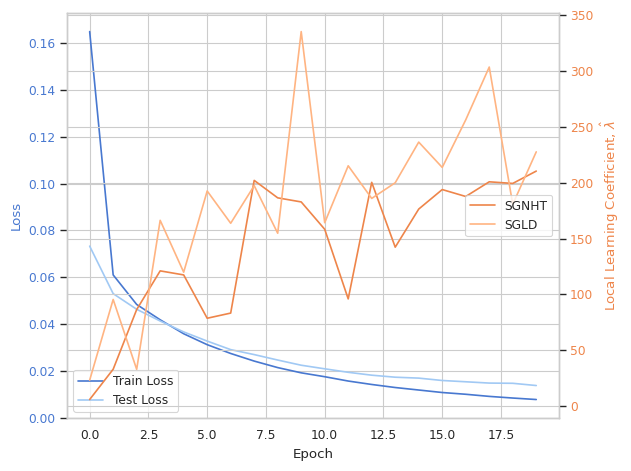

In [28]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_3:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_2-case_3/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_3, val_losses_toy_xp1_3, rlct_estimates_sgnht, rlct_estimates_sgld)


##### 1.4 XP1 - labels set $\mathcal{Card} = 2$ - $\mathcal{L}abels=\{5, other\}$

In [30]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## definition of the transformation to apply to dataset


## Load train data
batch_size = 512

train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_2_4)
# ---------------------------------------------------
n_classes = 2
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# ---------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1])
set of labels in test data:  tensor([0, 1])


In [31]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_resnet:
    train_losses_resnet_xp1_4 = []
    val_losses_resnet_xp1_4 = []
    train_acc_resnet_xp1_4 = []
    val_acc_resnet_xp1_4 = []
    models_resnet_xp1_4 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_4.append(train_loss)
        val_losses_resnet_xp1_4.append(val_loss)
        train_acc_resnet_xp1_4.append(train_acc)
        val_acc_resnet_xp1_4.append(val_acc)
        models_resnet_xp1_4 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_4, "XP1/card_2-case_4/resnet_models.pth")
    export_loss_acc_to_csv(path="XP1/card_2-case_4/resnet_loss_acc.csv",
                           train_loss=train_losses_resnet_xp1_4,
                           test_loss=val_losses_resnet_xp1_4,
                           train_acc=train_acc_resnet_xp1_4,
                           test_acc=val_acc_resnet_xp1_4)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_4 = []
    val_losses_toy_xp1_4 = []
    train_acc_toy_xp1_4 = []
    val_acc_toy_xp1_4 = []
    models_toy_xp1_4 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_4.append(train_loss)
        val_losses_toy_xp1_4.append(val_loss)
        train_acc_toy_xp1_4.append(train_acc)
        val_acc_toy_xp1_4.append(val_acc)
        models_toy_xp1_4 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_4, "XP1/card_2-case_4/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_2-case_4/toy_loss_acc.csv",
                           train_loss=train_losses_toy_xp1_4,
                           test_loss=val_losses_toy_xp1_4,
                           train_acc=train_acc_toy_xp1_4,
                           test_acc=val_acc_toy_xp1_4)

	train_loss: 0.20121 -- train_acc: 92.00 %: 100%|██████████| 118/118 [00:16<00:00,  6.96it/s]


Epoch 1:
Train Loss: 0.20198-- Val Loss: 0.10768-- Train Acc: 0.93-- Val Acc: 0.97


	train_loss: 0.08534 -- train_acc: 96.34 %: 100%|██████████| 118/118 [00:15<00:00,  7.49it/s]


Epoch 2:
Train Loss: 0.08583-- Val Loss: 0.06668-- Train Acc: 0.97-- Val Acc: 0.98


	train_loss: 0.05878 -- train_acc: 97.26 %: 100%|██████████| 118/118 [00:15<00:00,  7.54it/s]


Epoch 3:
Train Loss: 0.05937-- Val Loss: 0.05101-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04510 -- train_acc: 97.72 %: 100%|██████████| 118/118 [00:15<00:00,  7.53it/s]


Epoch 4:
Train Loss: 0.04562-- Val Loss: 0.04042-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03677 -- train_acc: 98.01 %: 100%|██████████| 118/118 [00:16<00:00,  7.35it/s]


Epoch 5:
Train Loss: 0.03721-- Val Loss: 0.03466-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03126 -- train_acc: 98.19 %: 100%|██████████| 118/118 [00:16<00:00,  7.33it/s]


Epoch 6:
Train Loss: 0.03130-- Val Loss: 0.02979-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02702 -- train_acc: 98.31 %: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]


Epoch 7:
Train Loss: 0.02715-- Val Loss: 0.02732-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02378 -- train_acc: 98.39 %: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


Epoch 8:
Train Loss: 0.02396-- Val Loss: 0.02451-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02108 -- train_acc: 98.46 %: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Epoch 9:
Train Loss: 0.02127-- Val Loss: 0.02219-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01904 -- train_acc: 98.55 %: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s]


Epoch 10:
Train Loss: 0.01910-- Val Loss: 0.02051-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01730 -- train_acc: 98.62 %: 100%|██████████| 118/118 [00:15<00:00,  7.75it/s]


Epoch 11:
Train Loss: 0.01737-- Val Loss: 0.01929-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01561 -- train_acc: 98.68 %: 100%|██████████| 118/118 [00:15<00:00,  7.58it/s]


Epoch 12:
Train Loss: 0.01642-- Val Loss: 0.01810-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01437 -- train_acc: 98.73 %: 100%|██████████| 118/118 [00:15<00:00,  7.64it/s]


Epoch 13:
Train Loss: 0.01462-- Val Loss: 0.01781-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01322 -- train_acc: 98.76 %: 100%|██████████| 118/118 [00:15<00:00,  7.42it/s]


Epoch 14:
Train Loss: 0.01337-- Val Loss: 0.01627-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01213 -- train_acc: 98.80 %: 100%|██████████| 118/118 [00:15<00:00,  7.55it/s]


Epoch 15:
Train Loss: 0.01224-- Val Loss: 0.01565-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01129 -- train_acc: 98.82 %: 100%|██████████| 118/118 [00:15<00:00,  7.51it/s]


Epoch 16:
Train Loss: 0.01131-- Val Loss: 0.01500-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.01033 -- train_acc: 98.88 %: 100%|██████████| 118/118 [00:18<00:00,  6.47it/s]


Epoch 17:
Train Loss: 0.01039-- Val Loss: 0.01462-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00961 -- train_acc: 98.88 %: 100%|██████████| 118/118 [00:15<00:00,  7.73it/s]


Epoch 18:
Train Loss: 0.00964-- Val Loss: 0.01428-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00879 -- train_acc: 98.90 %: 100%|██████████| 118/118 [00:15<00:00,  7.45it/s]


Epoch 19:
Train Loss: 0.00882-- Val Loss: 0.01344-- Train Acc: 1.00-- Val Acc: 1.00


	train_loss: 0.00803 -- train_acc: 98.95 %: 100%|██████████| 118/118 [00:15<00:00,  7.87it/s]


Epoch 20:
Train Loss: 0.00806-- Val Loss: 0.01327-- Train Acc: 1.00-- Val Acc: 1.00


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.44it/s] 


-214.1383914008708 -175.69174084633337


Chain 0: 100%|██████████| 400/400 [00:17<00:00, 23.00it/s] 


267.65144848109475 90.20414679680168


Chain 0: 100%|██████████| 400/400 [00:18<00:00, 21.64it/s] 


158.32261770799695 155.51652915546535


Chain 0: 100%|██████████| 400/400 [00:19<00:00, 20.07it/s]


206.9395426522088 115.52967780945407


Chain 0: 100%|██████████| 400/400 [00:19<00:00, 20.01it/s] 


187.00413314044243 203.13549036538282


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.29it/s] 


282.25247484230476 220.76468682414983


Chain 0: 100%|██████████| 400/400 [00:17<00:00, 23.43it/s] 


133.7019551330726 252.78044476641517


Chain 0: 100%|██████████| 400/400 [00:17<00:00, 22.86it/s] 


214.0806900533478 195.36481984103628


Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.50it/s] 


245.8527097276685 212.67675903940108


Chain 0: 100%|██████████| 400/400 [00:24<00:00, 16.09it/s] 


271.88512959301806 225.00496452999968


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 23.61it/s] 


509.92368987760113 179.08444997139867


Chain 0: 100%|██████████| 400/400 [00:17<00:00, 22.93it/s] 


280.4011212192934 202.59725411584398


Chain 0: 100%|██████████| 400/400 [00:18<00:00, 21.86it/s] 


201.83710485426045 233.5242543516589


Chain 0: 100%|██████████| 400/400 [00:21<00:00, 18.48it/s] 


262.55325544014977 216.956207134147


Chain 0: 100%|██████████| 400/400 [00:17<00:00, 23.38it/s] 


311.87179559465216 158.59203739354072


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.02it/s] 


247.25692984303686 186.7762466036815


Chain 0: 100%|██████████| 400/400 [00:19<00:00, 20.78it/s] 


269.89318974896395 202.06620092910163


Chain 0: 100%|██████████| 400/400 [00:32<00:00, 12.29it/s] 


383.4765683641125 230.4656909188506


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.33it/s] 


334.67738782570353 219.29499769293963


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.37it/s] 


327.81200501241455 233.61677413302672


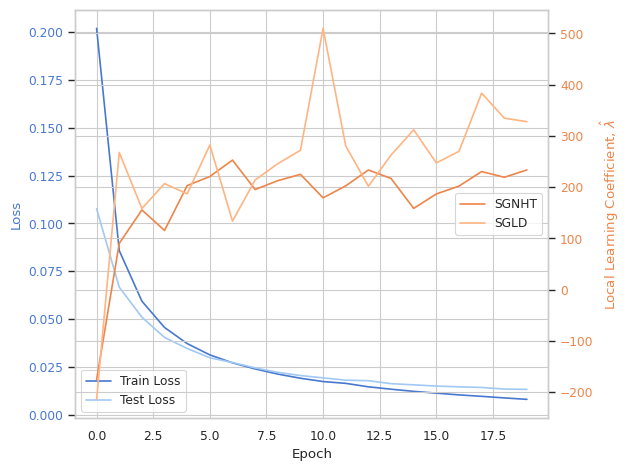

In [32]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_4:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_2-case_4/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_4, val_losses_toy_xp1_4, rlct_estimates_sgnht, rlct_estimates_sgld)


##### 1.5 XP1 - labels set $\mathcal{Card} = 2$ - $\mathcal{L}abels=\{9, other\}$

In [33]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## definition of the transformation to apply to dataset


## Load train data
batch_size = 512

train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_2_5)
# --------------------------------------------------
n_classes = 2
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# --------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1])
set of labels in test data:  tensor([0, 1])


In [36]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_resnet:
    train_losses_resnet_xp1_5 = []
    val_losses_resnet_xp1_5 = []
    train_acc_resnet_xp1_5 = []
    val_acc_resnet_xp1_5 = []
    models_resnet_xp1_5 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_5.append(train_loss)
        val_losses_resnet_xp1_5.append(val_loss)
        train_acc_resnet_xp1_5.append(train_acc)
        val_acc_resnet_xp1_5.append(val_acc)
        models_resnet_xp1_5 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_5, "XP1/card_2-case_5/resnet_models.pth")
    export_loss_acc_to_csv(path="XP1/card_2-case_5/resnet_loss_acc.csv",
                           train_loss=train_losses_resnet_xp1_5,
                           test_loss=val_losses_resnet_xp1_5,
                           train_acc=train_acc_resnet_xp1_5,
                           test_acc=val_acc_resnet_xp1_5)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_5 = []
    val_losses_toy_xp1_5 = []
    train_acc_toy_xp1_5 = []
    val_acc_toy_xp1_5 = []
    models_toy_xp1_5 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_5.append(train_loss)
        val_losses_toy_xp1_5.append(val_loss)
        train_acc_toy_xp1_5.append(train_acc)
        val_acc_toy_xp1_5.append(val_acc)
        models_toy_xp1_5 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_5, "XP1/card_2-case_5/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_2-case_5/toy_loss_acc.csv",
                            train_loss=train_losses_toy_xp1_5,
                            test_loss=val_losses_toy_xp1_5,
                            train_acc=train_acc_toy_xp1_5,
                            test_acc=val_acc_toy_xp1_5)

	train_loss: 0.01116 -- train_acc: 98.87 %: 100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


Epoch 1:
Train Loss: 0.01124-- Val Loss: 0.02290-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01024 -- train_acc: 98.90 %: 100%|██████████| 118/118 [00:15<00:00,  7.40it/s]


Epoch 2:
Train Loss: 0.01051-- Val Loss: 0.02249-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00960 -- train_acc: 98.92 %: 100%|██████████| 118/118 [00:15<00:00,  7.42it/s]


Epoch 3:
Train Loss: 0.00965-- Val Loss: 0.02194-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00883 -- train_acc: 98.96 %: 100%|██████████| 118/118 [00:25<00:00,  4.57it/s]


Epoch 4:
Train Loss: 0.00893-- Val Loss: 0.02176-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00822 -- train_acc: 98.97 %: 100%|██████████| 118/118 [00:28<00:00,  4.16it/s]


Epoch 5:
Train Loss: 0.00827-- Val Loss: 0.02185-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00763 -- train_acc: 98.99 %: 100%|██████████| 118/118 [00:29<00:00,  4.01it/s]


Epoch 6:
Train Loss: 0.00772-- Val Loss: 0.02157-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00707 -- train_acc: 99.02 %: 100%|██████████| 118/118 [00:30<00:00,  3.88it/s]


Epoch 7:
Train Loss: 0.00710-- Val Loss: 0.02093-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00659 -- train_acc: 99.04 %: 100%|██████████| 118/118 [00:28<00:00,  4.18it/s]


Epoch 8:
Train Loss: 0.00668-- Val Loss: 0.02157-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00618 -- train_acc: 99.04 %: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Epoch 9:
Train Loss: 0.00622-- Val Loss: 0.02122-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00575 -- train_acc: 99.07 %: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Epoch 10:
Train Loss: 0.00581-- Val Loss: 0.02160-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00530 -- train_acc: 99.07 %: 100%|██████████| 118/118 [00:16<00:00,  6.98it/s]


Epoch 11:
Train Loss: 0.00537-- Val Loss: 0.02121-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00491 -- train_acc: 99.08 %: 100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


Epoch 12:
Train Loss: 0.00500-- Val Loss: 0.02099-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00457 -- train_acc: 99.09 %: 100%|██████████| 118/118 [00:17<00:00,  6.56it/s]


Epoch 13:
Train Loss: 0.00464-- Val Loss: 0.02118-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00426 -- train_acc: 99.10 %: 100%|██████████| 118/118 [00:16<00:00,  7.16it/s]


Epoch 14:
Train Loss: 0.00431-- Val Loss: 0.02111-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00404 -- train_acc: 99.11 %: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Epoch 15:
Train Loss: 0.00408-- Val Loss: 0.02153-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00370 -- train_acc: 99.10 %: 100%|██████████| 118/118 [00:30<00:00,  3.87it/s]


Epoch 16:
Train Loss: 0.00372-- Val Loss: 0.02096-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00354 -- train_acc: 99.11 %: 100%|██████████| 118/118 [00:30<00:00,  3.86it/s]


Epoch 17:
Train Loss: 0.00356-- Val Loss: 0.02104-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00328 -- train_acc: 99.12 %: 100%|██████████| 118/118 [00:32<00:00,  3.64it/s]


Epoch 18:
Train Loss: 0.00332-- Val Loss: 0.02191-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00310 -- train_acc: 99.12 %: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


Epoch 19:
Train Loss: 0.00311-- Val Loss: 0.02117-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00290 -- train_acc: 99.12 %: 100%|██████████| 118/118 [00:15<00:00,  7.50it/s]


Epoch 20:
Train Loss: 0.00292-- Val Loss: 0.02136-- Train Acc: 1.00-- Val Acc: 0.99


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.61it/s] 


480.2604696993962 273.26047577293417


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.51it/s] 


472.0013285891547 287.21258177653635


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.35it/s] 


470.2690977540606 282.63974272875447


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.15it/s] 


476.10482998844856 276.19591898135207


Chain 0: 100%|██████████| 400/400 [00:18<00:00, 21.08it/s] 


466.029399190664 291.13640316630864


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 23.98it/s] 


526.6357843275027 308.8613736972907


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.00it/s] 


591.974566692563 289.98055820425236


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 23.94it/s] 


513.8404420656009 268.54222495081274


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 23.94it/s] 


513.7613532092315 294.9745191803439


Chain 0: 100%|██████████| 400/400 [00:29<00:00, 13.45it/s] 


454.7826044802183 289.5331449722394


Chain 0: 100%|██████████| 400/400 [00:28<00:00, 14.15it/s] 


511.845126851187 275.01640050334913


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.08it/s] 


491.2399722484331 318.8018914791481


Chain 0: 100%|██████████| 400/400 [00:19<00:00, 20.08it/s] 


571.9955323178042 304.32857514562767


Chain 0: 100%|██████████| 400/400 [00:18<00:00, 22.05it/s] 


500.30365496350015 302.4509212703997


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.22it/s] 


531.4299772369787 302.0276128447441


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 23.81it/s] 


564.9482097683979 313.8267037857753


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.27it/s] 


529.574730540841 297.8266681104381


Chain 0: 100%|██████████| 400/400 [00:34<00:00, 11.68it/s] 


682.8066842216771 321.5169610817076


Chain 0: 100%|██████████| 400/400 [00:16<00:00, 24.33it/s] 


518.0012024736563 302.3231925092402


Chain 0: 100%|██████████| 400/400 [00:22<00:00, 17.65it/s] 


567.6357302805292 281.8384567067397


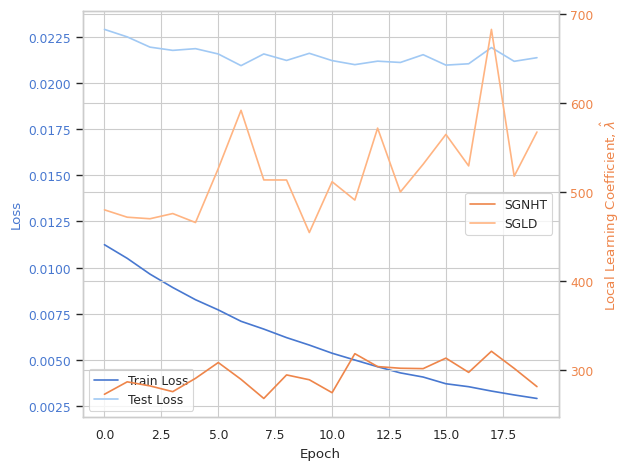

In [37]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_5:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_2-case_5/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_5, val_losses_toy_xp1_5, rlct_estimates_sgnht, rlct_estimates_sgld)


### Settings and runs label sets $Card(\mathcal{L}abels)=3$

* Labels modification and data loader
* Toy model for 3 classes
* Resnet18 model for 3 classes

In [10]:
# keys are the original label, values are the new labels
# [{2, 6, other} ; {3, 6, other} ; {0, 4, other} ; {8, 9, other} ; {5, 7, other}]
map_label_card_3_1 = {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 2, 7: 0, 8: 0, 9: 0}
map_label_card_3_2 = {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 2, 7: 0, 8: 0, 9: 0}
map_label_card_3_3 = {0: 1, 1: 0, 2: 0, 3: 0, 4: 2, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_3_4 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 2}
map_label_card_3_5 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 2, 8: 0, 9: 0}

##### 2.1 XP1 - labels set $\mathcal{Card} = 3$ - $\mathcal{L}abels=\{2, 6, other\}$

In [11]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_3_1)


# -------------------------------------------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1, 2])
set of labels in test data:  tensor([0, 1, 2])


In [12]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_resnet:
    train_losses_resnet_xp1_6 = []
    val_losses_resnet_xp1_6 = []
    train_acc_resnet_xp1_6 = []
    val_acc_resnet_xp1_6 = []
    models_resnet_xp1_6 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_6.append(train_loss)
        val_losses_resnet_xp1_6.append(val_loss)
        train_acc_resnet_xp1_6.append(train_acc)
        val_acc_resnet_xp1_6.append(val_acc)
        models_resnet_xp1_6 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_6, "XP1/card_3-case_1/resnet_models.pth")
    export_loss_acc_to_csv(path="XP1/card_3-case_1/resnet_loss_acc.csv",
                            train_loss=train_losses_resnet_xp1_6,
                            test_loss=val_losses_resnet_xp1_6,
                            train_acc=train_acc_resnet_xp1_6,
                            test_acc=val_acc_resnet_xp1_6)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_6 = []
    val_losses_toy_xp1_6 = []
    train_acc_toy_xp1_6 = []
    val_acc_toy_xp1_6 = []
    models_toy_xp1_6 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_6.append(train_loss)
        val_losses_toy_xp1_6.append(val_loss)
        train_acc_toy_xp1_6.append(train_acc)
        val_acc_toy_xp1_6.append(val_acc)
        models_toy_xp1_6 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_6, "XP1/card_3-case_1/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_3-case_1/toy_loss_acc.csv",
                                train_loss=train_losses_toy_xp1_6,
                                test_loss=val_losses_toy_xp1_6,
                                train_acc=train_acc_toy_xp1_6,
                                test_acc=val_acc_toy_xp1_6)

	train_loss: 0.28888 -- train_acc: 89.39 %: 100%|██████████| 118/118 [00:13<00:00,  8.68it/s]


Epoch 1:
Train Loss: 0.28971-- Val Loss: 0.12655-- Train Acc: 0.90-- Val Acc: 0.96


	train_loss: 0.10283 -- train_acc: 95.91 %: 100%|██████████| 118/118 [00:12<00:00,  9.32it/s]


Epoch 2:
Train Loss: 0.10390-- Val Loss: 0.09540-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.08283 -- train_acc: 96.57 %: 100%|██████████| 118/118 [00:12<00:00,  9.32it/s]


Epoch 3:
Train Loss: 0.08329-- Val Loss: 0.08083-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.07060 -- train_acc: 96.99 %: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]


Epoch 4:
Train Loss: 0.07177-- Val Loss: 0.07033-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.06148 -- train_acc: 97.27 %: 100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Epoch 5:
Train Loss: 0.06190-- Val Loss: 0.06370-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05424 -- train_acc: 97.55 %: 100%|██████████| 118/118 [00:13<00:00,  8.64it/s]


Epoch 6:
Train Loss: 0.05450-- Val Loss: 0.05777-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04805 -- train_acc: 97.73 %: 100%|██████████| 118/118 [00:13<00:00,  8.65it/s]


Epoch 7:
Train Loss: 0.04860-- Val Loss: 0.05290-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.04329 -- train_acc: 97.86 %: 100%|██████████| 118/118 [00:13<00:00,  8.90it/s]


Epoch 8:
Train Loss: 0.04343-- Val Loss: 0.04985-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03904 -- train_acc: 98.00 %: 100%|██████████| 118/118 [00:13<00:00,  8.93it/s]


Epoch 9:
Train Loss: 0.03974-- Val Loss: 0.04724-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03554 -- train_acc: 98.08 %: 100%|██████████| 118/118 [00:14<00:00,  8.40it/s]


Epoch 10:
Train Loss: 0.03666-- Val Loss: 0.04423-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03256 -- train_acc: 98.18 %: 100%|██████████| 118/118 [00:13<00:00,  8.72it/s]


Epoch 11:
Train Loss: 0.03261-- Val Loss: 0.04135-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02981 -- train_acc: 98.24 %: 100%|██████████| 118/118 [00:13<00:00,  8.88it/s]


Epoch 12:
Train Loss: 0.03003-- Val Loss: 0.04125-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02760 -- train_acc: 98.32 %: 100%|██████████| 118/118 [00:12<00:00,  9.10it/s]


Epoch 13:
Train Loss: 0.02785-- Val Loss: 0.03825-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02561 -- train_acc: 98.36 %: 100%|██████████| 118/118 [00:13<00:00,  8.85it/s]


Epoch 14:
Train Loss: 0.02575-- Val Loss: 0.03702-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02380 -- train_acc: 98.44 %: 100%|██████████| 118/118 [00:12<00:00,  9.35it/s]


Epoch 15:
Train Loss: 0.02397-- Val Loss: 0.03548-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02216 -- train_acc: 98.50 %: 100%|██████████| 118/118 [00:13<00:00,  8.83it/s]


Epoch 16:
Train Loss: 0.02224-- Val Loss: 0.03522-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02058 -- train_acc: 98.54 %: 100%|██████████| 118/118 [00:12<00:00,  9.25it/s]


Epoch 17:
Train Loss: 0.02072-- Val Loss: 0.03439-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01914 -- train_acc: 98.61 %: 100%|██████████| 118/118 [00:13<00:00,  8.81it/s]


Epoch 18:
Train Loss: 0.01920-- Val Loss: 0.03328-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01799 -- train_acc: 98.64 %: 100%|██████████| 118/118 [00:13<00:00,  8.67it/s]


Epoch 19:
Train Loss: 0.01838-- Val Loss: 0.03462-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01695 -- train_acc: 98.68 %: 100%|██████████| 118/118 [00:13<00:00,  8.65it/s]


Epoch 20:
Train Loss: 0.01704-- Val Loss: 0.03203-- Train Acc: 1.00-- Val Acc: 0.99


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.05it/s] 


80.73099345750576 46.55440994639818


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.52it/s] 


168.98195339972645 221.81268208721397


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.69it/s] 


208.14341519028292 207.60758468460375


Chain 0: 100%|██████████| 400/400 [00:14<00:00, 28.31it/s] 


303.80843870715114 164.37761563245215


Chain 0: 100%|██████████| 400/400 [00:14<00:00, 28.34it/s] 


461.831883036883 49.08377628365045


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.79it/s] 


543.2451344925764 88.80045252642655


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 28.97it/s] 


443.6491617220394 268.56791325676727


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.28it/s] 


399.0781474400805 125.82346805637343


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.16it/s] 


440.86752478710366 332.944702873395


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 28.92it/s] 


449.4190180959009 226.3868894131643


Chain 0: 100%|██████████| 400/400 [00:14<00:00, 28.09it/s] 


432.99065124894526 333.20739064533257


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.54it/s] 


423.76521458696925 293.07256004126606


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.91it/s] 


419.2417187117391 344.5384396915018


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.67it/s] 


465.10438048692515 280.2546979550288


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.00it/s] 


466.5427807046178 255.83496528055812


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.15it/s] 


410.3631337295063 354.17178326705334


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.13it/s] 


316.38756763626424 301.97083540980094


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.14it/s] 


466.17697218176755 268.85501278906963


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.88it/s] 


539.8751328090636 316.07302631792237


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.10it/s] 


462.74793010522 329.8236416391007


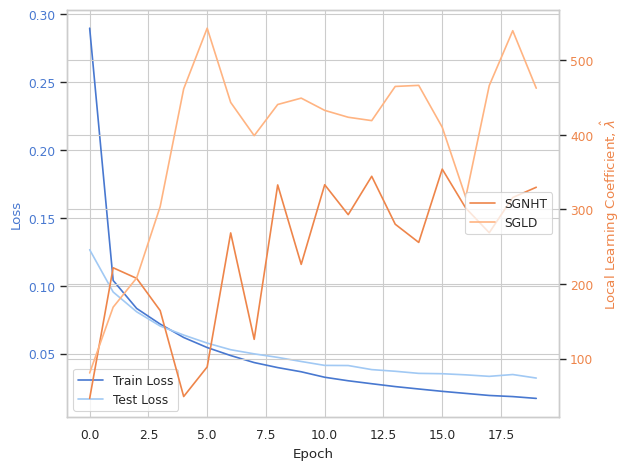

In [13]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_6:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_3-case_1/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_6, val_losses_toy_xp1_6, rlct_estimates_sgnht, rlct_estimates_sgld)


##### 2.2 XP1 - labels set $\mathcal{Card} = 3$ - $\mathcal{L}abels=\{3, 6, other\}$

In [14]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_3_2)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1, 2])
set of labels in test data:  tensor([0, 1, 2])


In [15]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

if run_resnet:
    train_losses_resnet_xp1_7 = []
    val_losses_resnet_xp1_7 = []
    train_acc_resnet_xp1_7 = []
    val_acc_resnet_xp1_7 = []
    models_resnet_xp1_7 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_7.append(train_loss)
        val_losses_resnet_xp1_7.append(val_loss)
        train_acc_resnet_xp1_7.append(train_acc)
        val_acc_resnet_xp1_7.append(val_acc)
        models_resnet_xp1_7 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_7, "XP1/card_3-case_2/resnet_models.pth")
    export_loss_acc_to_csv(path="XP1/card_3-case_2/resnet_loss_acc.csv",
                                train_loss=train_losses_resnet_xp1_7,
                                test_loss=val_losses_resnet_xp1_7,
                                train_acc=train_acc_resnet_xp1_7,
                                test_acc=val_acc_resnet_xp1_7)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_7 = []
    val_losses_toy_xp1_7 = []
    train_acc_toy_xp1_7 = []
    val_acc_toy_xp1_7 = []
    models_toy_xp1_7 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_7.append(train_loss)
        val_losses_toy_xp1_7.append(val_loss)
        train_acc_toy_xp1_7.append(train_acc)
        val_acc_toy_xp1_7.append(val_acc)
        models_toy_xp1_7 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_7, "XP1/card_3-case_2/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_3-case_2/toy_loss_acc.csv",
                                train_loss=train_losses_toy_xp1_7,
                                test_loss=val_losses_toy_xp1_7,
                                train_acc=train_acc_toy_xp1_7,
                                test_acc=val_acc_toy_xp1_7)

	train_loss: 0.33614 -- train_acc: 87.10 %: 100%|██████████| 118/118 [00:12<00:00,  9.15it/s]


Epoch 1:
Train Loss: 0.33813-- Val Loss: 0.14048-- Train Acc: 0.88-- Val Acc: 0.96


	train_loss: 0.12370 -- train_acc: 95.34 %: 100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch 2:
Train Loss: 0.12441-- Val Loss: 0.09996-- Train Acc: 0.96-- Val Acc: 0.97


	train_loss: 0.09774 -- train_acc: 96.10 %: 100%|██████████| 118/118 [00:12<00:00,  9.31it/s]


Epoch 3:
Train Loss: 0.09868-- Val Loss: 0.08482-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.08304 -- train_acc: 96.51 %: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]


Epoch 4:
Train Loss: 0.08356-- Val Loss: 0.07281-- Train Acc: 0.97-- Val Acc: 0.98


	train_loss: 0.07176 -- train_acc: 96.92 %: 100%|██████████| 118/118 [00:12<00:00,  9.18it/s]


Epoch 5:
Train Loss: 0.07259-- Val Loss: 0.06464-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.06305 -- train_acc: 97.18 %: 100%|██████████| 118/118 [00:12<00:00,  9.21it/s]


Epoch 6:
Train Loss: 0.06340-- Val Loss: 0.05951-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05574 -- train_acc: 97.45 %: 100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch 7:
Train Loss: 0.05673-- Val Loss: 0.05418-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04994 -- train_acc: 97.61 %: 100%|██████████| 118/118 [00:12<00:00,  9.38it/s]


Epoch 8:
Train Loss: 0.05014-- Val Loss: 0.04936-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04469 -- train_acc: 97.77 %: 100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch 9:
Train Loss: 0.04572-- Val Loss: 0.04626-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.04036 -- train_acc: 97.90 %: 100%|██████████| 118/118 [00:12<00:00,  9.31it/s]


Epoch 10:
Train Loss: 0.04083-- Val Loss: 0.04395-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03651 -- train_acc: 98.03 %: 100%|██████████| 118/118 [00:12<00:00,  9.10it/s]


Epoch 11:
Train Loss: 0.03676-- Val Loss: 0.04163-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03311 -- train_acc: 98.15 %: 100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Epoch 12:
Train Loss: 0.03324-- Val Loss: 0.03964-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03047 -- train_acc: 98.23 %: 100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Epoch 13:
Train Loss: 0.03062-- Val Loss: 0.03751-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02785 -- train_acc: 98.33 %: 100%|██████████| 118/118 [00:12<00:00,  9.21it/s]


Epoch 14:
Train Loss: 0.02800-- Val Loss: 0.03647-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02536 -- train_acc: 98.43 %: 100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch 15:
Train Loss: 0.02538-- Val Loss: 0.03593-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02333 -- train_acc: 98.50 %: 100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch 16:
Train Loss: 0.02357-- Val Loss: 0.03668-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02152 -- train_acc: 98.54 %: 100%|██████████| 118/118 [00:12<00:00,  9.28it/s]


Epoch 17:
Train Loss: 0.02157-- Val Loss: 0.03387-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01971 -- train_acc: 98.57 %: 100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch 18:
Train Loss: 0.01988-- Val Loss: 0.03320-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01823 -- train_acc: 98.67 %: 100%|██████████| 118/118 [00:12<00:00,  9.23it/s]


Epoch 19:
Train Loss: 0.01845-- Val Loss: 0.03234-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01680 -- train_acc: 98.70 %: 100%|██████████| 118/118 [00:12<00:00,  9.10it/s]


Epoch 20:
Train Loss: 0.01692-- Val Loss: 0.03203-- Train Acc: 1.00-- Val Acc: 0.99


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.99it/s] 


145.98043125562933 -130.10740856513482


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.53it/s] 


317.79686570125705 -18.42943125107714


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.63it/s] 


365.9836767023831 271.3664021184482


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.94it/s] 


543.2662651990873 201.87451779195064


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.10it/s] 


440.0335056396007 141.88232521947486


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.96it/s] 


384.32687592644317 292.5291698416389


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.36it/s] 


574.3471706213594 262.9629335879907


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.59it/s] 


811.0313633681225 304.963100503688


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.76it/s] 


651.9675650883506 275.1193444076393


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.29it/s] 


624.1445745374481 356.807151033728


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.08it/s] 


523.0655068135206 469.5755268287631


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.26it/s] 


598.2308960927234 390.87936243685874


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.46it/s] 


584.4823329618313 281.0092202364886


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.33it/s] 


503.2239443073269 375.4146262876845


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.49it/s] 


594.24430962375 334.0841741129441


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.32it/s] 


618.0363215624219 451.4399698488496


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.84it/s] 


622.82419526284 430.04863853656656


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.47it/s] 


529.6487980876442 379.81963717957456


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 31.01it/s] 


637.7667077256489 421.98973582477237


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.91it/s] 


665.6414183729722 416.790907230939


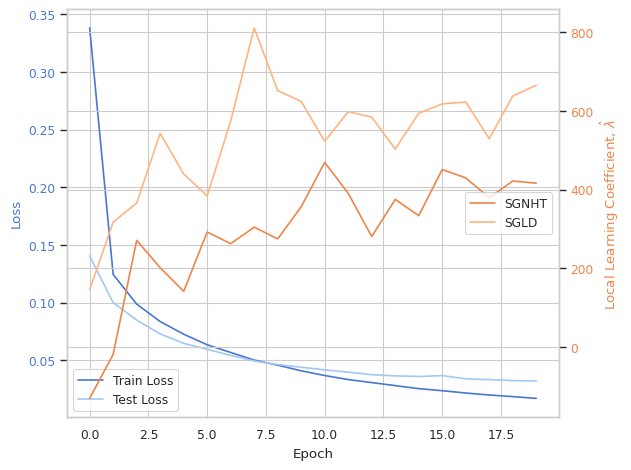

In [16]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_7:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_3-case_2/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_7, val_losses_toy_xp1_7, rlct_estimates_sgnht, rlct_estimates_sgld)


##### 2.3 XP1 - labels set $\mathcal{Card} = 3$ - $\mathcal{L}abels=\{0, 4, other\}$

In [17]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_3_3)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 2])
set of labels in test data:  tensor([0, 2])


In [18]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_resnet:
    train_losses_resnet_xp1_8 = []
    val_losses_resnet_xp1_8 = []
    train_acc_resnet_xp1_8 = []
    val_acc_resnet_xp1_8 = []
    models_resnet_xp1_8 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_8.append(train_loss)
        val_losses_resnet_xp1_8.append(val_loss)
        train_acc_resnet_xp1_8.append(train_acc)
        val_acc_resnet_xp1_8.append(val_acc)
        models_resnet_xp1_8 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_8, "XP1/card_3-case_3/resnet_models.pth")
    export_loss_acc_to_csv(path="XP1/card_3-case_3/resnet_loss_acc.csv",
                                train_loss=train_losses_resnet_xp1_8,
                                test_loss=val_losses_resnet_xp1_8,
                                train_acc=train_acc_resnet_xp1_8,
                                test_acc=val_acc_resnet_xp1_8)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_8 = []
    val_losses_toy_xp1_8 = []
    train_acc_toy_xp1_8 = []
    val_acc_toy_xp1_8 = []
    models_toy_xp1_8 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_8.append(train_loss)
        val_losses_toy_xp1_8.append(val_loss)
        train_acc_toy_xp1_8.append(train_acc)
        val_acc_toy_xp1_8.append(val_acc)
        models_toy_xp1_8 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_8, "XP1/card_3-case_3/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_3-case_3/toy_loss_acc.csv",
                                train_loss=train_losses_toy_xp1_8,
                                test_loss=val_losses_toy_xp1_8,
                                train_acc=train_acc_toy_xp1_8,
                                test_acc=val_acc_toy_xp1_8)

	train_loss: 0.18628 -- train_acc: 92.93 %: 100%|██████████| 118/118 [00:12<00:00,  9.32it/s]


Epoch 1:
Train Loss: 0.18722-- Val Loss: 0.07542-- Train Acc: 0.94-- Val Acc: 0.98


	train_loss: 0.06099 -- train_acc: 97.27 %: 100%|██████████| 118/118 [00:12<00:00,  9.53it/s]


Epoch 2:
Train Loss: 0.06143-- Val Loss: 0.05423-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04877 -- train_acc: 97.63 %: 100%|██████████| 118/118 [00:12<00:00,  9.64it/s]


Epoch 3:
Train Loss: 0.04889-- Val Loss: 0.04701-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04174 -- train_acc: 97.84 %: 100%|██████████| 118/118 [00:12<00:00,  9.60it/s]


Epoch 4:
Train Loss: 0.04182-- Val Loss: 0.04180-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03622 -- train_acc: 98.03 %: 100%|██████████| 118/118 [00:12<00:00,  9.58it/s]


Epoch 5:
Train Loss: 0.03690-- Val Loss: 0.03701-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03144 -- train_acc: 98.19 %: 100%|██████████| 118/118 [00:12<00:00,  9.45it/s]


Epoch 6:
Train Loss: 0.03228-- Val Loss: 0.03351-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02759 -- train_acc: 98.32 %: 100%|██████████| 118/118 [00:12<00:00,  9.40it/s]


Epoch 7:
Train Loss: 0.02810-- Val Loss: 0.03011-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02438 -- train_acc: 98.40 %: 100%|██████████| 118/118 [00:12<00:00,  9.47it/s]


Epoch 8:
Train Loss: 0.02450-- Val Loss: 0.02750-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02156 -- train_acc: 98.52 %: 100%|██████████| 118/118 [00:12<00:00,  9.38it/s]


Epoch 9:
Train Loss: 0.02184-- Val Loss: 0.02521-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01929 -- train_acc: 98.60 %: 100%|██████████| 118/118 [00:12<00:00,  9.17it/s]


Epoch 10:
Train Loss: 0.01942-- Val Loss: 0.02333-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01726 -- train_acc: 98.65 %: 100%|██████████| 118/118 [00:12<00:00,  9.22it/s]


Epoch 11:
Train Loss: 0.01740-- Val Loss: 0.02154-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01543 -- train_acc: 98.68 %: 100%|██████████| 118/118 [00:12<00:00,  9.42it/s]


Epoch 12:
Train Loss: 0.01560-- Val Loss: 0.01975-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01395 -- train_acc: 98.75 %: 100%|██████████| 118/118 [00:12<00:00,  9.42it/s]


Epoch 13:
Train Loss: 0.01401-- Val Loss: 0.01819-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01272 -- train_acc: 98.77 %: 100%|██████████| 118/118 [00:12<00:00,  9.40it/s]


Epoch 14:
Train Loss: 0.01283-- Val Loss: 0.01741-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01152 -- train_acc: 98.82 %: 100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch 15:
Train Loss: 0.01160-- Val Loss: 0.01694-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01046 -- train_acc: 98.85 %: 100%|██████████| 118/118 [00:12<00:00,  9.20it/s]


Epoch 16:
Train Loss: 0.01068-- Val Loss: 0.01572-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00963 -- train_acc: 98.87 %: 100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch 17:
Train Loss: 0.00968-- Val Loss: 0.01518-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00877 -- train_acc: 98.93 %: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 18:
Train Loss: 0.00906-- Val Loss: 0.01471-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00818 -- train_acc: 98.95 %: 100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch 19:
Train Loss: 0.00826-- Val Loss: 0.01423-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00739 -- train_acc: 98.99 %: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 20:
Train Loss: 0.00744-- Val Loss: 0.01347-- Train Acc: 1.00-- Val Acc: 0.99


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.90it/s] 


-62.68724093657638 42.24307600340865


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.59it/s] 


91.74801530425039 67.58940859409095


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.71it/s] 


149.57505590006062 54.33128118421685


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.80it/s] 


164.68070334886357 22.446888764339995


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 31.02it/s] 


200.06941036544558 108.81736740901644


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.55it/s] 


235.1466672782727 25.264040091924425


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.04it/s] 


187.1016130075461 160.03014391651664


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.98it/s] 


108.1675951491253 182.84475391907972


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.25it/s] 


138.56258492629655 195.3654749395123


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 31.00it/s] 


163.3123139064132 210.8862037939224


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 31.02it/s] 


234.93389703758362 153.40772325825805


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.69it/s] 


209.14803485359144 141.72802765705367


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.45it/s] 


253.85871960211173 203.40506669593898


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.97it/s] 


241.3710633608495 201.10250480146647


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.99it/s] 


408.1691560866665 187.7002663181147


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.58it/s] 


260.5434513636157 167.2462006722858


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.71it/s] 


234.03418168865724 60.09372271005645


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.50it/s] 


231.7608786268149 213.34616314727035


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.84it/s] 


270.99194474154933 185.58864918305198


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.46it/s] 


219.05745552612584 201.73490819051722


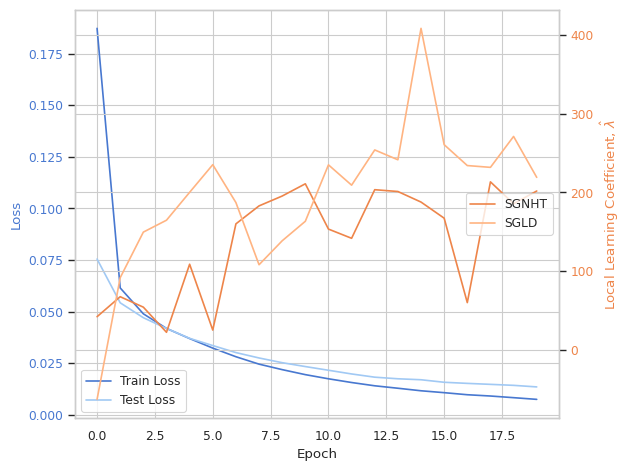

In [19]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_8:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_3-case_3/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_8, val_losses_toy_xp1_8, rlct_estimates_sgnht, rlct_estimates_sgld)


##### 2.4 XP1 - labels set $\mathcal{Card} = 3$ - $\mathcal{L}abels=\{8, 9, other\}$

In [20]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_3_4)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1, 2])
set of labels in test data:  tensor([0, 1, 2])


In [21]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_resnet:
    train_losses_resnet_xp1_9 = []
    val_losses_resnet_xp1_9 = []
    train_acc_resnet_xp1_9 = []
    val_acc_resnet_xp1_9 = []
    models_resnet_xp1_9 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_9.append(train_loss)
        val_losses_resnet_xp1_9.append(val_loss)
        train_acc_resnet_xp1_9.append(train_acc)
        val_acc_resnet_xp1_9.append(val_acc)
        models_resnet_xp1_9 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_9, "XP1/card_3-case_4/resnet_models.pth")
    export_loss_acc_to_csv(path="XP1/card_3-case_4/resnet_loss_acc.csv",
                                train_loss=train_losses_resnet_xp1_9,
                                test_loss=val_losses_resnet_xp1_9,
                                train_acc=train_acc_resnet_xp1_9,
                                test_acc=val_acc_resnet_xp1_9)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_9 = []
    val_losses_toy_xp1_9 = []
    train_acc_toy_xp1_9 = []
    val_acc_toy_xp1_9 = []
    models_toy_xp1_9 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_9.append(train_loss)
        val_losses_toy_xp1_9.append(val_loss)
        train_acc_toy_xp1_9.append(train_acc)
        val_acc_toy_xp1_9.append(val_acc)
        models_toy_xp1_9 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_9, "XP1/card_3-case_4/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_3-case_4/toy_loss_acc.csv",
                                train_loss=train_losses_toy_xp1_9,
                                test_loss=val_losses_toy_xp1_9,
                                train_acc=train_acc_toy_xp1_9,
                                test_acc=val_acc_toy_xp1_9)

	train_loss: 0.40136 -- train_acc: 84.49 %: 100%|██████████| 118/118 [00:12<00:00,  9.21it/s]


Epoch 1:
Train Loss: 0.40310-- Val Loss: 0.20759-- Train Acc: 0.85-- Val Acc: 0.94


	train_loss: 0.17630 -- train_acc: 93.30 %: 100%|██████████| 118/118 [00:12<00:00,  9.52it/s]


Epoch 2:
Train Loss: 0.17853-- Val Loss: 0.14812-- Train Acc: 0.94-- Val Acc: 0.95


	train_loss: 0.13056 -- train_acc: 94.93 %: 100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Epoch 3:
Train Loss: 0.13138-- Val Loss: 0.11572-- Train Acc: 0.96-- Val Acc: 0.96


	train_loss: 0.10370 -- train_acc: 95.90 %: 100%|██████████| 118/118 [00:12<00:00,  9.53it/s]


Epoch 4:
Train Loss: 0.10440-- Val Loss: 0.10494-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.08676 -- train_acc: 96.51 %: 100%|██████████| 118/118 [00:12<00:00,  9.53it/s]


Epoch 5:
Train Loss: 0.08755-- Val Loss: 0.08302-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.07433 -- train_acc: 96.87 %: 100%|██████████| 118/118 [00:12<00:00,  9.51it/s]


Epoch 6:
Train Loss: 0.07528-- Val Loss: 0.07431-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.06511 -- train_acc: 97.17 %: 100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch 7:
Train Loss: 0.06562-- Val Loss: 0.06899-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05793 -- train_acc: 97.39 %: 100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch 8:
Train Loss: 0.05835-- Val Loss: 0.06389-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05219 -- train_acc: 97.58 %: 100%|██████████| 118/118 [00:12<00:00,  9.31it/s]


Epoch 9:
Train Loss: 0.05250-- Val Loss: 0.05996-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04731 -- train_acc: 97.75 %: 100%|██████████| 118/118 [00:12<00:00,  9.28it/s]


Epoch 10:
Train Loss: 0.04833-- Val Loss: 0.05681-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.04327 -- train_acc: 97.88 %: 100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Epoch 11:
Train Loss: 0.04352-- Val Loss: 0.05480-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03963 -- train_acc: 97.97 %: 100%|██████████| 118/118 [00:12<00:00,  9.31it/s]


Epoch 12:
Train Loss: 0.03980-- Val Loss: 0.05172-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03607 -- train_acc: 98.10 %: 100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch 13:
Train Loss: 0.03697-- Val Loss: 0.05049-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03360 -- train_acc: 98.19 %: 100%|██████████| 118/118 [00:12<00:00,  9.41it/s]


Epoch 14:
Train Loss: 0.03396-- Val Loss: 0.04824-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03113 -- train_acc: 98.24 %: 100%|██████████| 118/118 [00:12<00:00,  9.35it/s]


Epoch 15:
Train Loss: 0.03123-- Val Loss: 0.04799-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.02853 -- train_acc: 98.35 %: 100%|██████████| 118/118 [00:12<00:00,  9.29it/s]


Epoch 16:
Train Loss: 0.02865-- Val Loss: 0.04585-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.02628 -- train_acc: 98.42 %: 100%|██████████| 118/118 [00:12<00:00,  9.43it/s]


Epoch 17:
Train Loss: 0.02641-- Val Loss: 0.04561-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.02429 -- train_acc: 98.49 %: 100%|██████████| 118/118 [00:12<00:00,  9.48it/s]


Epoch 18:
Train Loss: 0.02436-- Val Loss: 0.04385-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02248 -- train_acc: 98.56 %: 100%|██████████| 118/118 [00:12<00:00,  9.43it/s]


Epoch 19:
Train Loss: 0.02264-- Val Loss: 0.04312-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02098 -- train_acc: 98.59 %: 100%|██████████| 118/118 [00:12<00:00,  9.47it/s]


Epoch 20:
Train Loss: 0.02101-- Val Loss: 0.04441-- Train Acc: 0.99-- Val Acc: 0.99


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.23it/s] 


278.4026892843313 -311.7100087074368


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 31.14it/s] 


557.8227013879306 168.10505505847098


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.13it/s] 


771.8919119619868 182.34414317489703


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.45it/s] 


702.0349023359212 305.0185166821412


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.87it/s] 


619.6577972155856 394.7189790045335


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 31.02it/s] 


730.9011691502441 372.29417298726463


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.27it/s] 


855.2375148317742 473.3646327936561


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.56it/s] 


943.7657008994581 276.75335232206015


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.75it/s] 


812.8130067830919 480.9306038681905


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.97it/s] 


943.9600211657252 495.2111157228242


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.61it/s] 


771.8399459544503 575.0063060926783


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.30it/s] 


955.2196361119526 417.56644646263936


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.36it/s] 


802.5705504021854 454.32835096203905


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.27it/s] 


1029.9100494999236 584.1669832616456


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.47it/s] 


927.9769830963281 527.9214244891077


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.44it/s] 


911.2723082623331 508.90957850487916


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.16it/s] 


1051.681146749443 501.4113464132592


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.14it/s] 


1076.1169630545999 531.1839255704042


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.23it/s] 


1022.1438750845446 550.8158010892073


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.71it/s] 


977.5857114518852 528.6539668091875


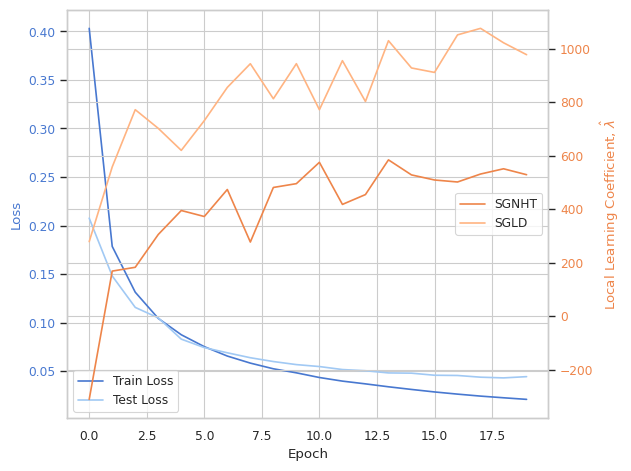

In [22]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_9:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_3-case_4/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_9, val_losses_toy_xp1_9, rlct_estimates_sgnht, rlct_estimates_sgld)


##### 2.5 XP1 - labels set $\mathcal{Card} = 3$ - $\mathcal{L}abels=\{5, 7, other\}$

In [23]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_3_5)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1, 2])
set of labels in test data:  tensor([0, 1, 2])


In [24]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_resnet:
    train_losses_resnet_xp1_10 = []
    val_losses_resnet_xp1_10 = []
    models_resnet_xp1_10 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_10.append(train_loss)
        val_losses_resnet_xp1_10.append(val_loss)
        models_resnet_xp1_10 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_10, "XP1/card_3-case_5/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_10 = []
    val_losses_toy_xp1_10 = []
    train_acc_toy_xp1_10 = []
    val_acc_toy_xp1_10 = []
    models_toy_xp1_10 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_10.append(train_loss)
        val_losses_toy_xp1_10.append(val_loss)
        train_acc_toy_xp1_10.append(train_acc)
        val_acc_toy_xp1_10.append(val_acc)
        models_toy_xp1_10 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_10, "XP1/card_3-case_5/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_3-case_5/toy_loss_acc.csv",
                                train_loss=train_losses_toy_xp1_10,
                                test_loss=val_losses_toy_xp1_10,
                                train_acc=train_acc_toy_xp1_10,
                                test_acc=val_acc_toy_xp1_10)

	train_loss: 0.35652 -- train_acc: 86.50 %: 100%|██████████| 118/118 [00:12<00:00,  9.22it/s]


Epoch 1:
Train Loss: 0.35781-- Val Loss: 0.17498-- Train Acc: 0.87-- Val Acc: 0.95


	train_loss: 0.14157 -- train_acc: 94.63 %: 100%|██████████| 118/118 [00:12<00:00,  9.40it/s]


Epoch 2:
Train Loss: 0.14254-- Val Loss: 0.11757-- Train Acc: 0.95-- Val Acc: 0.97


	train_loss: 0.10413 -- train_acc: 95.86 %: 100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Epoch 3:
Train Loss: 0.10474-- Val Loss: 0.09506-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.08477 -- train_acc: 96.45 %: 100%|██████████| 118/118 [00:12<00:00,  9.17it/s]


Epoch 4:
Train Loss: 0.08517-- Val Loss: 0.08101-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.07218 -- train_acc: 96.95 %: 100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Epoch 5:
Train Loss: 0.07243-- Val Loss: 0.07195-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.06313 -- train_acc: 97.22 %: 100%|██████████| 118/118 [00:12<00:00,  9.18it/s]


Epoch 6:
Train Loss: 0.06341-- Val Loss: 0.06534-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05621 -- train_acc: 97.43 %: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]


Epoch 7:
Train Loss: 0.05693-- Val Loss: 0.06003-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05075 -- train_acc: 97.60 %: 100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch 8:
Train Loss: 0.05119-- Val Loss: 0.05710-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04641 -- train_acc: 97.76 %: 100%|██████████| 118/118 [00:12<00:00,  9.25it/s]


Epoch 9:
Train Loss: 0.04687-- Val Loss: 0.05288-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.04242 -- train_acc: 97.90 %: 100%|██████████| 118/118 [00:12<00:00,  9.32it/s]


Epoch 10:
Train Loss: 0.04294-- Val Loss: 0.04964-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03915 -- train_acc: 98.02 %: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 11:
Train Loss: 0.03988-- Val Loss: 0.04723-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03633 -- train_acc: 98.08 %: 100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch 12:
Train Loss: 0.03639-- Val Loss: 0.04582-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03370 -- train_acc: 98.17 %: 100%|██████████| 118/118 [00:12<00:00,  9.28it/s]


Epoch 13:
Train Loss: 0.03377-- Val Loss: 0.04505-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03131 -- train_acc: 98.26 %: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 14:
Train Loss: 0.03146-- Val Loss: 0.04297-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02910 -- train_acc: 98.32 %: 100%|██████████| 118/118 [00:13<00:00,  9.02it/s]


Epoch 15:
Train Loss: 0.02920-- Val Loss: 0.04098-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02724 -- train_acc: 98.38 %: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]


Epoch 16:
Train Loss: 0.02738-- Val Loss: 0.04158-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02532 -- train_acc: 98.45 %: 100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Epoch 17:
Train Loss: 0.02566-- Val Loss: 0.03916-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02352 -- train_acc: 98.51 %: 100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Epoch 18:
Train Loss: 0.02399-- Val Loss: 0.03897-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02222 -- train_acc: 98.55 %: 100%|██████████| 118/118 [00:12<00:00,  9.44it/s]


Epoch 19:
Train Loss: 0.02229-- Val Loss: 0.03805-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02064 -- train_acc: 98.60 %: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 20:
Train Loss: 0.02077-- Val Loss: 0.03689-- Train Acc: 0.99-- Val Acc: 0.99


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.96it/s] 


47.14161902573933 -374.14671488651067


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.14it/s] 


336.16623785723465 -169.84231247573877


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.34it/s] 


374.6701867301879 143.73691793133605


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.79it/s] 


340.2329877184136 241.23264986361602


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.66it/s] 


539.6913694649587 247.82753943957573


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.92it/s] 


637.9703922064405 350.5476107774521


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.74it/s] 


582.2552899049496 372.66107988854935


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.99it/s] 


442.6523265606667 365.8882565107003


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.88it/s] 


652.5770878683066 360.2952721288905


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.36it/s] 


643.8558894537291 409.6518416622352


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.95it/s] 


657.1062131488696 429.0022075904581


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.62it/s] 


751.7934995047949 262.043078116161


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.75it/s] 


561.3994186698885 331.233958704548


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.75it/s] 


562.1756476767447 419.00019158685086


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.88it/s] 


587.4359151846246 414.32941253934365


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.74it/s] 


550.8755395107269 268.3064346610333


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.08it/s] 


798.145917982153 403.86750397170107


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.35it/s] 


656.6494754389373 386.402163471668


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.12it/s] 


662.5130871048386 303.80578004319483


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.86it/s] 


608.5171930405531 405.4082627898031


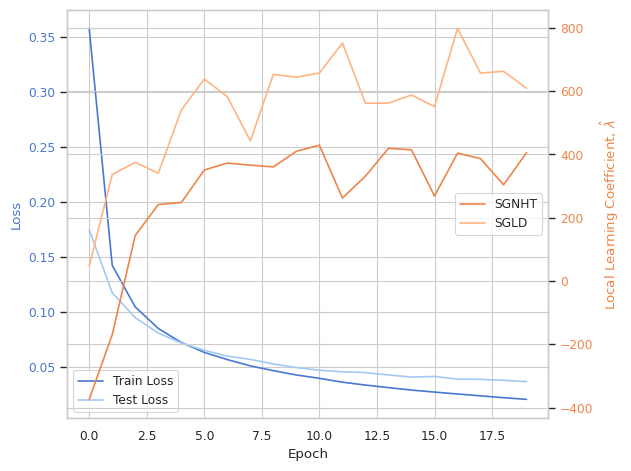

In [25]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_10:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_3-case_5/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_10, val_losses_toy_xp1_10, rlct_estimates_sgnht, rlct_estimates_sgld)


### Settings and runs label sets $Card(\mathcal{L}abels)=4$

* Labels modification and data loader
* Toy model for 4 classes
* Resnet18 model for 4 classes

In [26]:
# keys are the original label, values are the new labels
# [{0, 5, 6, other} ; {6, 7, 9, other} ; {2, 3, 5, other} ; {0, 1, 4, other}]
map_label_card_4_1 = {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 2, 6: 3, 7: 0, 8: 0, 9: 0}
map_label_card_4_2 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 2, 8: 0, 9: 3}
map_label_card_4_3 = {0: 0, 1: 0, 2: 1, 3: 2, 4: 0, 5: 3, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_4_4 = {0: 1, 1: 2, 2: 0, 3: 0, 4: 3, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

##### 3.1 XP1 - labels set $\mathcal{Card} = 4$ - $\mathcal{L}abels=\{0, 5, 6, other\}$

In [27]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_4_1)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 4
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 2, 3])
set of labels in test data:  tensor([0, 2, 3])


In [28]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_resnet:
    train_losses_resnet_xp1_11 = []
    val_losses_resnet_xp1_11 = []
    models_resnet_xp1_11 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_11.append(train_loss)
        val_losses_resnet_xp1_11.append(val_loss)
        models_resnet_xp1_11 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_11, "XP1/card_4-case_1/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_11 = []
    val_losses_toy_xp1_11 = []
    train_acc_toy_xp1_11 = []
    val_acc_toy_xp1_11 = []
    models_toy_xp1_11 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_11.append(train_loss)
        val_losses_toy_xp1_11.append(val_loss)
        train_acc_toy_xp1_11.append(train_acc)
        val_acc_toy_xp1_11.append(val_acc)
        models_toy_xp1_11 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_11, "XP1/card_4-case_1/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_4-case_1/toy_loss_acc.csv",
                                train_loss=train_losses_toy_xp1_11,
                                test_loss=val_losses_toy_xp1_11,
                                train_acc=train_acc_toy_xp1_11,
                                test_acc=val_acc_toy_xp1_11)

	train_loss: 0.34756 -- train_acc: 87.31 %: 100%|██████████| 118/118 [00:12<00:00,  9.45it/s]


Epoch 1:
Train Loss: 0.34855-- Val Loss: 0.14484-- Train Acc: 0.88-- Val Acc: 0.95


	train_loss: 0.11572 -- train_acc: 95.39 %: 100%|██████████| 118/118 [00:12<00:00,  9.46it/s]


Epoch 2:
Train Loss: 0.11652-- Val Loss: 0.09097-- Train Acc: 0.96-- Val Acc: 0.97


	train_loss: 0.08074 -- train_acc: 96.55 %: 100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Epoch 3:
Train Loss: 0.08161-- Val Loss: 0.06940-- Train Acc: 0.97-- Val Acc: 0.98


	train_loss: 0.06317 -- train_acc: 97.16 %: 100%|██████████| 118/118 [00:12<00:00,  9.16it/s]


Epoch 4:
Train Loss: 0.06428-- Val Loss: 0.05800-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05268 -- train_acc: 97.54 %: 100%|██████████| 118/118 [00:12<00:00,  9.41it/s]


Epoch 5:
Train Loss: 0.05296-- Val Loss: 0.05059-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04526 -- train_acc: 97.73 %: 100%|██████████| 118/118 [00:12<00:00,  9.23it/s]


Epoch 6:
Train Loss: 0.04566-- Val Loss: 0.04491-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03973 -- train_acc: 97.90 %: 100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Epoch 7:
Train Loss: 0.04035-- Val Loss: 0.04148-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03560 -- train_acc: 98.06 %: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 8:
Train Loss: 0.03585-- Val Loss: 0.03826-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03195 -- train_acc: 98.20 %: 100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Epoch 9:
Train Loss: 0.03278-- Val Loss: 0.03656-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02942 -- train_acc: 98.24 %: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]


Epoch 10:
Train Loss: 0.02956-- Val Loss: 0.03388-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02684 -- train_acc: 98.34 %: 100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Epoch 11:
Train Loss: 0.02742-- Val Loss: 0.03211-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02470 -- train_acc: 98.40 %: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 12:
Train Loss: 0.02476-- Val Loss: 0.03117-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02264 -- train_acc: 98.46 %: 100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch 13:
Train Loss: 0.02315-- Val Loss: 0.03020-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02110 -- train_acc: 98.51 %: 100%|██████████| 118/118 [00:12<00:00,  9.67it/s]


Epoch 14:
Train Loss: 0.02117-- Val Loss: 0.02870-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01949 -- train_acc: 98.56 %: 100%|██████████| 118/118 [00:12<00:00,  9.56it/s]


Epoch 15:
Train Loss: 0.01961-- Val Loss: 0.02839-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01817 -- train_acc: 98.60 %: 100%|██████████| 118/118 [00:12<00:00,  9.61it/s]


Epoch 16:
Train Loss: 0.01823-- Val Loss: 0.02724-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01679 -- train_acc: 98.65 %: 100%|██████████| 118/118 [00:12<00:00,  9.58it/s]


Epoch 17:
Train Loss: 0.01684-- Val Loss: 0.02633-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01568 -- train_acc: 98.69 %: 100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch 18:
Train Loss: 0.01575-- Val Loss: 0.02599-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01465 -- train_acc: 98.73 %: 100%|██████████| 118/118 [00:12<00:00,  9.31it/s]


Epoch 19:
Train Loss: 0.01478-- Val Loss: 0.02526-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01366 -- train_acc: 98.77 %: 100%|██████████| 118/118 [00:12<00:00,  9.50it/s]


Epoch 20:
Train Loss: 0.01375-- Val Loss: 0.02606-- Train Acc: 1.00-- Val Acc: 0.99


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.98it/s] 


-56.62164985149536 -171.07230652114131


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.04it/s] 


494.6467629560469 120.88838787615181


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.02it/s] 


453.95062117823545 219.0066299763048


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.56it/s] 


602.9993068178004 261.0617836624384


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.84it/s] 


354.19656787473565 209.49531517315697


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.11it/s] 


587.9379080820921 289.7360443995393


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.64it/s] 


529.4905325404374 254.15029367044912


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.76it/s] 


367.05209611080045 287.15106819724565


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.75it/s] 


460.8598860028576 191.3615170157717


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.78it/s] 


582.5944341307587 287.16538522187903


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.50it/s] 


512.0145372210613 330.5376287167197


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.34it/s] 


428.9157788929568 296.66241042684095


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.47it/s] 


611.4755034813239 242.16517466545326


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.99it/s] 


740.852251015614 304.76984456134977


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.08it/s] 


456.696244698849 344.5802926980548


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.63it/s] 


622.385106332231 326.85351072322254


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.27it/s] 


648.5702850220176 359.48745026062596


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.56it/s] 


699.9686272102414 347.83749879256567


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.41it/s] 


545.2600587884775 288.0309938024847


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.73it/s] 


672.743166488655 334.30738909400657


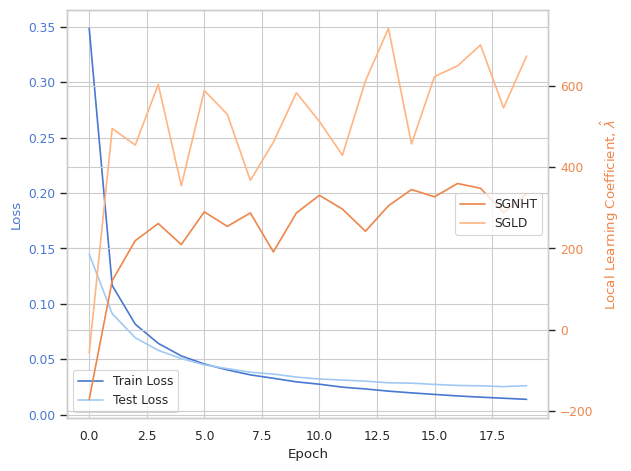

In [29]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_11:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_4-case_1/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_11, val_losses_toy_xp1_11, rlct_estimates_sgnht, rlct_estimates_sgld)


##### 3.2 XP1 - labels set $\mathcal{Card} = 4$ - $\mathcal{L}abels=\{6, 7, 9, other\}$

In [30]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_4_2)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 4
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1, 2, 3])
set of labels in test data:  tensor([0, 1, 2, 3])


In [31]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_resnet:
    train_losses_resnet_xp1_12 = []
    val_losses_resnet_xp1_12 = []
    models_resnet_xp1_12 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_12.append(train_loss)
        val_losses_resnet_xp1_12.append(val_loss)
        models_resnet_xp1_12 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_12, "XP1/card_4-case_2/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_12 = []
    val_losses_toy_xp1_12 = []
    train_acc_toy_xp1_12 = []
    val_acc_toy_xp1_12 = []
    models_toy_xp1_12 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_12.append(train_loss)
        val_losses_toy_xp1_12.append(val_loss)
        train_acc_toy_xp1_12.append(train_acc)
        val_acc_toy_xp1_12.append(val_acc)
        models_toy_xp1_12 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_12, "XP1/card_4-case_2/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_4-case_2/toy_loss_acc.csv",
                                train_loss=train_losses_toy_xp1_12,
                                test_loss=val_losses_toy_xp1_12,
                                train_acc=train_acc_toy_xp1_12,
                                test_acc=val_acc_toy_xp1_12)

	train_loss: 0.45444 -- train_acc: 83.65 %: 100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Epoch 1:
Train Loss: 0.45569-- Val Loss: 0.20768-- Train Acc: 0.84-- Val Acc: 0.94


	train_loss: 0.17076 -- train_acc: 93.99 %: 100%|██████████| 118/118 [00:12<00:00,  9.33it/s]


Epoch 2:
Train Loss: 0.17216-- Val Loss: 0.16155-- Train Acc: 0.95-- Val Acc: 0.95


	train_loss: 0.13881 -- train_acc: 94.89 %: 100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Epoch 3:
Train Loss: 0.13937-- Val Loss: 0.14040-- Train Acc: 0.96-- Val Acc: 0.96


	train_loss: 0.11995 -- train_acc: 95.48 %: 100%|██████████| 118/118 [00:12<00:00,  9.19it/s]


Epoch 4:
Train Loss: 0.12177-- Val Loss: 0.12418-- Train Acc: 0.96-- Val Acc: 0.96


	train_loss: 0.10605 -- train_acc: 95.91 %: 100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Epoch 5:
Train Loss: 0.10685-- Val Loss: 0.11323-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.09457 -- train_acc: 96.30 %: 100%|██████████| 118/118 [00:12<00:00,  9.29it/s]


Epoch 6:
Train Loss: 0.09537-- Val Loss: 0.10425-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.08530 -- train_acc: 96.54 %: 100%|██████████| 118/118 [00:12<00:00,  9.25it/s]


Epoch 7:
Train Loss: 0.08582-- Val Loss: 0.09639-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.07739 -- train_acc: 96.81 %: 100%|██████████| 118/118 [00:12<00:00,  9.19it/s]


Epoch 8:
Train Loss: 0.07857-- Val Loss: 0.08923-- Train Acc: 0.98-- Val Acc: 0.97


	train_loss: 0.07094 -- train_acc: 97.04 %: 100%|██████████| 118/118 [00:12<00:00,  9.32it/s]


Epoch 9:
Train Loss: 0.07131-- Val Loss: 0.08420-- Train Acc: 0.98-- Val Acc: 0.97


	train_loss: 0.06550 -- train_acc: 97.23 %: 100%|██████████| 118/118 [00:12<00:00,  9.42it/s]


Epoch 10:
Train Loss: 0.06596-- Val Loss: 0.07897-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.06007 -- train_acc: 97.39 %: 100%|██████████| 118/118 [00:12<00:00,  9.46it/s]


Epoch 11:
Train Loss: 0.06030-- Val Loss: 0.07674-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05585 -- train_acc: 97.52 %: 100%|██████████| 118/118 [00:12<00:00,  9.33it/s]


Epoch 12:
Train Loss: 0.05647-- Val Loss: 0.07217-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05210 -- train_acc: 97.63 %: 100%|██████████| 118/118 [00:12<00:00,  9.57it/s]


Epoch 13:
Train Loss: 0.05236-- Val Loss: 0.06984-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04867 -- train_acc: 97.76 %: 100%|██████████| 118/118 [00:12<00:00,  9.62it/s]


Epoch 14:
Train Loss: 0.04918-- Val Loss: 0.06738-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.04524 -- train_acc: 97.85 %: 100%|██████████| 118/118 [00:12<00:00,  9.57it/s]


Epoch 15:
Train Loss: 0.04543-- Val Loss: 0.06710-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.04266 -- train_acc: 97.95 %: 100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch 16:
Train Loss: 0.04279-- Val Loss: 0.06387-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03973 -- train_acc: 98.04 %: 100%|██████████| 118/118 [00:12<00:00,  9.38it/s]


Epoch 17:
Train Loss: 0.04001-- Val Loss: 0.06236-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03729 -- train_acc: 98.12 %: 100%|██████████| 118/118 [00:12<00:00,  9.53it/s]


Epoch 18:
Train Loss: 0.03736-- Val Loss: 0.06121-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03507 -- train_acc: 98.18 %: 100%|██████████| 118/118 [00:12<00:00,  9.56it/s]


Epoch 19:
Train Loss: 0.03514-- Val Loss: 0.05982-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03288 -- train_acc: 98.26 %: 100%|██████████| 118/118 [00:12<00:00,  9.65it/s]


Epoch 20:
Train Loss: 0.03302-- Val Loss: 0.05827-- Train Acc: 0.99-- Val Acc: 0.98


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.60it/s] 


159.46286177658766 -103.10150780606567


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.28it/s] 


331.0263099974098 121.17406149982793


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.92it/s] 


377.12222348753215 51.08716328886374


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.73it/s] 


371.6130192337238 334.8402168607871


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.71it/s] 


565.7974449471063 424.2980779319469


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.72it/s] 


601.3030930284932 246.73372039808729


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.86it/s] 


656.0717975580152 288.30556314955993


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.04it/s] 


757.2714148038192 422.16530752386706


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.40it/s] 


697.9836467415441 401.31323604534936


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.41it/s] 


701.9940221492719 313.84421631215776


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.10it/s] 


717.0433260755614 304.29984192308825


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.15it/s] 


700.0075463931938 525.0650633598062


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.33it/s] 


755.4238582201012 427.83168594273144


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.01it/s] 


854.9366708781154 553.3582302498047


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.00it/s] 


978.7492094276469 517.5146580386016


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.57it/s] 


839.6189602068881 536.1298069967248


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.10it/s] 


784.9309739726325 401.96968529928995


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.26it/s] 


843.130747380478 510.7959086955211


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.12it/s] 


879.8101896434706 511.63401547568736


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.30it/s] 


754.1627460003403 504.1446037042029


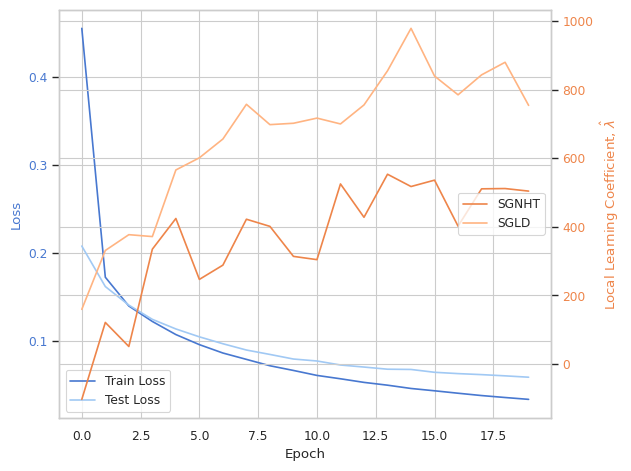

In [32]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_12:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_4-case_2/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_12, val_losses_toy_xp1_12, rlct_estimates_sgnht, rlct_estimates_sgld)


##### 3.3 XP1 - labels set $\mathcal{Card} = 4$ - $\mathcal{L}abels=\{2, 3, 5, other\}$

In [33]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_4_3)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 4
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

set of labels in train data:  tensor([0, 1, 2, 3])
set of labels in test data:  tensor([0, 1, 2, 3])


In [34]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_resnet:
    train_losses_resnet_xp1_13 = []
    val_losses_resnet_xp1_13 = []
    models_resnet_xp1_13 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_13.append(train_loss)
        val_losses_resnet_xp1_13.append(val_loss)
        models_resnet_xp1_13 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_13, "XP1/card_4-case_3/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_13 = []
    val_losses_toy_xp1_13 = []
    train_acc_toy_xp1_13 = []
    val_acc_toy_xp1_13 = []
    models_toy_xp1_13 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_13.append(train_loss)
        val_losses_toy_xp1_13.append(val_loss)
        train_acc_toy_xp1_13.append(train_acc)
        val_acc_toy_xp1_13.append(val_acc)
        models_toy_xp1_13 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_13, "XP1/card_4-case_3/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_4-case_3/toy_loss_acc.csv",
                                train_loss=train_losses_toy_xp1_13,
                                test_loss=val_losses_toy_xp1_13,
                                train_acc=train_acc_toy_xp1_13,
                                test_acc=val_acc_toy_xp1_13)

	train_loss: 0.51415 -- train_acc: 81.65 %: 100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch 1:
Train Loss: 0.51728-- Val Loss: 0.23884-- Train Acc: 0.82-- Val Acc: 0.93


	train_loss: 0.19833 -- train_acc: 93.13 %: 100%|██████████| 118/118 [00:12<00:00,  9.19it/s]


Epoch 2:
Train Loss: 0.19928-- Val Loss: 0.15880-- Train Acc: 0.94-- Val Acc: 0.95


	train_loss: 0.14542 -- train_acc: 94.79 %: 100%|██████████| 118/118 [00:12<00:00,  9.23it/s]


Epoch 3:
Train Loss: 0.14729-- Val Loss: 0.12476-- Train Acc: 0.96-- Val Acc: 0.96


	train_loss: 0.11772 -- train_acc: 95.64 %: 100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch 4:
Train Loss: 0.11820-- Val Loss: 0.10494-- Train Acc: 0.96-- Val Acc: 0.97


	train_loss: 0.09953 -- train_acc: 96.23 %: 100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Epoch 5:
Train Loss: 0.10001-- Val Loss: 0.09171-- Train Acc: 0.97-- Val Acc: 0.97


	train_loss: 0.08638 -- train_acc: 96.61 %: 100%|██████████| 118/118 [00:12<00:00,  9.21it/s]


Epoch 6:
Train Loss: 0.08742-- Val Loss: 0.08110-- Train Acc: 0.97-- Val Acc: 0.98


	train_loss: 0.07669 -- train_acc: 96.92 %: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 7:
Train Loss: 0.07762-- Val Loss: 0.07306-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.06901 -- train_acc: 97.14 %: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 8:
Train Loss: 0.06928-- Val Loss: 0.06857-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.06218 -- train_acc: 97.35 %: 100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch 9:
Train Loss: 0.06335-- Val Loss: 0.06384-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05686 -- train_acc: 97.50 %: 100%|██████████| 118/118 [00:12<00:00,  9.35it/s]


Epoch 10:
Train Loss: 0.05738-- Val Loss: 0.05939-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.05205 -- train_acc: 97.66 %: 100%|██████████| 118/118 [00:12<00:00,  9.29it/s]


Epoch 11:
Train Loss: 0.05221-- Val Loss: 0.05711-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.04780 -- train_acc: 97.79 %: 100%|██████████| 118/118 [00:12<00:00,  9.20it/s]


Epoch 12:
Train Loss: 0.04808-- Val Loss: 0.05357-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.04400 -- train_acc: 97.91 %: 100%|██████████| 118/118 [00:12<00:00,  9.31it/s]


Epoch 13:
Train Loss: 0.04418-- Val Loss: 0.05160-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.04061 -- train_acc: 98.00 %: 100%|██████████| 118/118 [00:12<00:00,  9.29it/s]


Epoch 14:
Train Loss: 0.04094-- Val Loss: 0.04968-- Train Acc: 0.99-- Val Acc: 0.98


	train_loss: 0.03762 -- train_acc: 98.09 %: 100%|██████████| 118/118 [00:12<00:00,  9.35it/s]


Epoch 15:
Train Loss: 0.03785-- Val Loss: 0.04762-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03473 -- train_acc: 98.18 %: 100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch 16:
Train Loss: 0.03514-- Val Loss: 0.04535-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03211 -- train_acc: 98.27 %: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 17:
Train Loss: 0.03247-- Val Loss: 0.04453-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02972 -- train_acc: 98.33 %: 100%|██████████| 118/118 [00:12<00:00,  9.10it/s]


Epoch 18:
Train Loss: 0.02979-- Val Loss: 0.04404-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02752 -- train_acc: 98.40 %: 100%|██████████| 118/118 [00:12<00:00,  9.22it/s]


Epoch 19:
Train Loss: 0.02795-- Val Loss: 0.04303-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02576 -- train_acc: 98.45 %: 100%|██████████| 118/118 [00:12<00:00,  9.33it/s]


Epoch 20:
Train Loss: 0.02591-- Val Loss: 0.04194-- Train Acc: 0.99-- Val Acc: 0.99


In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_13:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_4-case_3/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_13, val_losses_toy_xp1_13, rlct_estimates_sgnht, rlct_estimates_sgld)


##### 3.4 XP1 - labels set $\mathcal{Card} = 4$ - $\mathcal{L}abels=\{0, 1, 4, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_4_4)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 4
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model",
                                                            optim_cfg=dict_optim_cfg,
                                                            nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18
if run_resnet:
    models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                    optim_cfg=dict_optim_cfg,
                                                                    nb_classes=n_classes)

In [37]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_resnet:
    train_losses_resnet_xp1_14 = []
    val_losses_resnet_xp1_14 = []
    models_resnet_xp1_14 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_resnet18,
                                        optimizer_resnet18,
                                        criterion_resnet18,
                                        train_loader)
        val_loss, val_acc = val_step(model_resnet18,
                                    criterion_resnet18,
                                    test_loader)
        train_losses_resnet_xp1_14.append(train_loss)
        val_losses_resnet_xp1_14.append(val_loss)
        models_resnet_xp1_14 += [copy.deepcopy(model_resnet18)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_resnet_xp1_14, "XP1/card_4-case_4/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
if run_toy_model:
    train_losses_toy_xp1_14 = []
    val_losses_toy_xp1_14 = []
    train_acc_toy_xp1_14 = []
    val_acc_toy_xp1_14 = []
    models_toy_xp1_14 = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_step(model_toy,
                                        optimizer_toy,
                                        criterion_toy,
                                        train_loader)
        val_loss, val_acc = val_step(model_toy,
                                    criterion_toy,
                                    test_loader)
        train_losses_toy_xp1_14.append(train_loss)
        val_losses_toy_xp1_14.append(val_loss)
        train_acc_toy_xp1_14.append(train_acc)
        val_acc_toy_xp1_14.append(val_acc)
        models_toy_xp1_14 += [copy.deepcopy(model_toy)]

        print_step_report(epoch=epoch,
                        train_loss=train_loss,
                        val_loss=val_loss,
                        train_acc=train_acc,
                        val_acc=val_acc)

    torch.save(models_toy_xp1_14, "XP1/card_4-case_4/toy_models.pth")
    export_loss_acc_to_csv(path="XP1/card_4-case_4/toy_loss_acc.csv",
                                train_loss=train_losses_toy_xp1_14,
                                test_loss=val_losses_toy_xp1_14,
                                train_acc=train_acc_toy_xp1_14,
                                test_acc=val_acc_toy_xp1_14)

	train_loss: 0.19810 -- train_acc: 92.78 %: 100%|██████████| 118/118 [00:12<00:00,  9.28it/s]


Epoch 1:
Train Loss: 0.19930-- Val Loss: 0.07284-- Train Acc: 0.94-- Val Acc: 0.98


	train_loss: 0.06025 -- train_acc: 97.27 %: 100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch 2:
Train Loss: 0.06052-- Val Loss: 0.05364-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04868 -- train_acc: 97.63 %: 100%|██████████| 118/118 [00:12<00:00,  9.49it/s]


Epoch 3:
Train Loss: 0.04956-- Val Loss: 0.04858-- Train Acc: 0.98-- Val Acc: 0.98


	train_loss: 0.04193 -- train_acc: 97.86 %: 100%|██████████| 118/118 [00:12<00:00,  9.45it/s]


Epoch 4:
Train Loss: 0.04217-- Val Loss: 0.04254-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03662 -- train_acc: 98.04 %: 100%|██████████| 118/118 [00:12<00:00,  9.44it/s]


Epoch 5:
Train Loss: 0.03673-- Val Loss: 0.03706-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.03164 -- train_acc: 98.17 %: 100%|██████████| 118/118 [00:12<00:00,  9.32it/s]


Epoch 6:
Train Loss: 0.03334-- Val Loss: 0.03312-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02798 -- train_acc: 98.32 %: 100%|██████████| 118/118 [00:12<00:00,  9.25it/s]


Epoch 7:
Train Loss: 0.02810-- Val Loss: 0.02987-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02462 -- train_acc: 98.42 %: 100%|██████████| 118/118 [00:12<00:00,  9.50it/s]


Epoch 8:
Train Loss: 0.02466-- Val Loss: 0.02825-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.02194 -- train_acc: 98.51 %: 100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch 9:
Train Loss: 0.02196-- Val Loss: 0.02535-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01957 -- train_acc: 98.59 %: 100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch 10:
Train Loss: 0.01966-- Val Loss: 0.02295-- Train Acc: 0.99-- Val Acc: 0.99


	train_loss: 0.01754 -- train_acc: 98.66 %: 100%|██████████| 118/118 [00:12<00:00,  9.22it/s]


Epoch 11:
Train Loss: 0.01769-- Val Loss: 0.02096-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01576 -- train_acc: 98.71 %: 100%|██████████| 118/118 [00:12<00:00,  9.19it/s]


Epoch 12:
Train Loss: 0.01584-- Val Loss: 0.02015-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01427 -- train_acc: 98.74 %: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]


Epoch 13:
Train Loss: 0.01434-- Val Loss: 0.01846-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01300 -- train_acc: 98.80 %: 100%|██████████| 118/118 [00:12<00:00,  9.39it/s]


Epoch 14:
Train Loss: 0.01314-- Val Loss: 0.01721-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01190 -- train_acc: 98.80 %: 100%|██████████| 118/118 [00:12<00:00,  9.44it/s]


Epoch 15:
Train Loss: 0.01200-- Val Loss: 0.01678-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.01082 -- train_acc: 98.84 %: 100%|██████████| 118/118 [00:12<00:00,  9.61it/s]


Epoch 16:
Train Loss: 0.01087-- Val Loss: 0.01609-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00985 -- train_acc: 98.90 %: 100%|██████████| 118/118 [00:12<00:00,  9.45it/s]


Epoch 17:
Train Loss: 0.00987-- Val Loss: 0.01500-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00910 -- train_acc: 98.89 %: 100%|██████████| 118/118 [00:12<00:00,  9.42it/s]


Epoch 18:
Train Loss: 0.00913-- Val Loss: 0.01471-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00841 -- train_acc: 98.93 %: 100%|██████████| 118/118 [00:12<00:00,  9.54it/s]


Epoch 19:
Train Loss: 0.00844-- Val Loss: 0.01462-- Train Acc: 1.00-- Val Acc: 0.99


	train_loss: 0.00775 -- train_acc: 98.96 %: 100%|██████████| 118/118 [00:12<00:00,  9.54it/s]


Epoch 20:
Train Loss: 0.00777-- Val Loss: 0.01374-- Train Acc: 1.00-- Val Acc: 0.99


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.60it/s] 


-13.027019870164317 2.2028540729158794


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.95it/s] 


189.0416964070077 23.82401883151008


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.62it/s] 


133.64344104848738 107.97388482927525


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.81it/s] 


212.7794757327149 148.72308437769692


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.06it/s] 


186.0976578642062 180.44433397726567


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.86it/s] 


245.80595376746328 162.05631642072976


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.47it/s] 


125.68389467435742 158.1901398146068


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.72it/s] 


161.88958818918442 153.12311117301206


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 31.00it/s] 


207.8419829139294 180.74927812134524


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.91it/s] 


176.31976027646203 181.79029368364243


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 31.03it/s] 


223.25540231322555 120.48359468335686


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.60it/s] 


413.8842311408483 202.42455090572676


Chain 0: 100%|██████████| 400/400 [00:12<00:00, 30.93it/s] 


320.5890070036947 159.4649522432749


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.34it/s] 


290.4131529933185 134.87867986750038


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.54it/s] 


300.73932353273176 217.29097674634204


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.47it/s] 


395.6884121101235 194.41155943859954


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.59it/s] 


313.866139141454 205.45753106571667


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.07it/s] 


337.5242372153966 220.44031401635772


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 30.44it/s] 


367.1684455134866 195.54493339476227


Chain 0: 100%|██████████| 400/400 [00:13<00:00, 29.79it/s] 


263.26724753642776 172.86337531732724


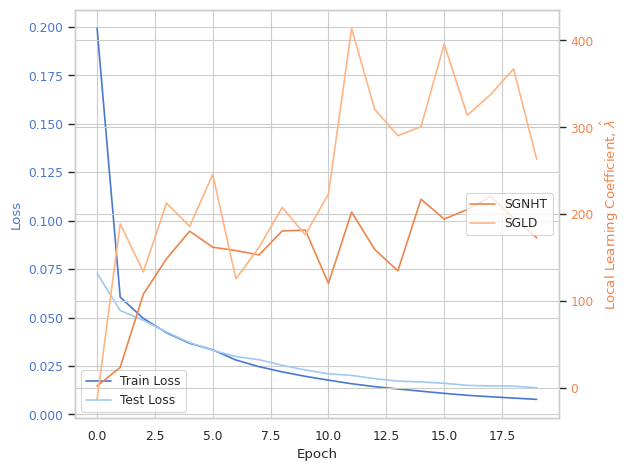

In [38]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy Model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models_toy_xp1_14:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion_toy,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

# plotting
export_rlct_to_csv("XP1/card_4-case_4/toy_rlct_estimated.csv",
                    rlct_estimates_sgnht=rlct_estimates_sgnht,
                    rlct_estimates_sgld=rlct_estimates_sgld)
plot_lambda_vs_epochs(train_losses_toy_xp1_14, val_losses_toy_xp1_14, rlct_estimates_sgnht, rlct_estimates_sgld)


### Settings and runs label sets $Card(\mathcal{L}abels)=5$

* Labels modification and data loader
* Toy model for 5 classes
* Resnet18 model for 5 classes

In [ ]:
# keys are the original label, values are the new labels
# {0, 1, 4, 5, other} ; {0, 1, 7, 8, other} ; {4, 5, 7, 9, other} ; {2, 3, 6, 7, other}
map_label_card_5_1 = {0: 1, 1: 2, 2: 0, 3: 0, 4: 3, 5: 4, 6: 0, 7: 0, 8: 0, 9: 0}
map_label_card_5_2 = {0: 1, 1: 2, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 3, 8: 4, 9: 0}
map_label_card_5_3 = {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 2, 6: 0, 7: 3, 8: 0, 9: 4}
map_label_card_5_4 = {0: 0, 1: 0, 2: 1, 3: 2, 4: 0, 5: 0, 6: 3, 7: 4, 8: 0, 9: 0}

##### 4.1 XP1 - labels set $\mathcal{Card} = 5$ - $\mathcal{L}abels=\{0, 1, 4, 5, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_5_1)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model"1,
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_15 = []
val_losses_resnet_xp1_15 = []
models_resnet_xp1_15 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_15.append(train_loss)
    val_losses_resnet_xp1_15.append(val_loss)
    models_resnet_xp1_15 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_15, "XP1/card_5-case_1/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_15 = []
val_losses_toy_xp1_15 = []
models_toy_xp1_15 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_15.append(train_loss)
    val_losses_toy_xp1_15.append(val_loss)
    models_toy_xp1_15 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_15, "XP1/card_5-case_1/toy_models.pth")

In [39]:
!tar -cvf XP1.tar.gz XP1

XP1/
XP1/card_5-case_1/
XP1/card_2-case_5/
XP1/card_2-case_2/
XP1/card_10-case_1/
XP1/card_5-case_3/
XP1/card_10-case_5/
XP1/card_2-case_4/
XP1/card_4-case_4/
XP1/card_4-case_4/toy_rlct_estimated.csv
XP1/card_4-case_4/toy_models.pth
XP1/card_4-case_4/toy_loss_acc.csv
XP1/card_5-case_2/
XP1/card_10-case_3/
XP1/card_4-case_2/
XP1/card_4-case_2/toy_rlct_estimated.csv
XP1/card_4-case_2/toy_models.pth
XP1/card_4-case_2/toy_loss_acc.csv
XP1/card_4-case_3/
XP1/card_4-case_3/toy_rlct_estimated.csv
XP1/card_4-case_3/toy_models.pth
XP1/card_4-case_3/toy_loss_acc.csv
XP1/card_3-case_1/
XP1/card_3-case_1/toy_rlct_estimated.csv
XP1/card_3-case_1/toy_models.pth
XP1/card_3-case_1/toy_loss_acc.csv
XP1/card_3-case_3/
XP1/card_3-case_3/toy_rlct_estimated.csv
XP1/card_3-case_3/toy_models.pth
XP1/card_3-case_3/toy_loss_acc.csv
XP1/card_3-case_4/
XP1/card_3-case_4/toy_rlct_estimated.csv
XP1/card_3-case_4/toy_models.pth
XP1/card_3-case_4/toy_loss_acc.csv
XP1/card_5-case_4/
XP1/card_2-case_1/
XP1/card_4-case

##### 4.2 XP1 - labels set $\mathcal{Card} = 5$ - $\mathcal{L}abels=\{0, 1, 7, 8, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_5_2)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 3
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model"1,
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_16 = []
val_losses_resnet_xp1_16 = []
models_resnet_xp1_16 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_16.append(train_loss)
    val_losses_resnet_xp1_16.append(val_loss)
    models_resnet_xp1_16 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_16, "XP1/card_5-case_2/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_16 = []
val_losses_toy_xp1_16 = []
models_toy_xp1_16 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_16.append(train_loss)
    val_losses_toy_xp1_16.append(val_loss)
    models_toy_xp1_16 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_16, "XP1/card_5-case_2/toy_models.pth")

##### 4.3 XP1 - labels set $\mathcal{Card} = 5$ - $\mathcal{L}abels=\{4, 5, 7, 9, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_5_3)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 5
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model"1,
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_17 = []
val_losses_resnet_xp1_17 = []
models_resnet_xp1_17 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_17.append(train_loss)
    val_losses_resnet_xp1_17.append(val_loss)
    models_resnet_xp1_17 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_17, "XP1/card_5-case_3/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_17 = []
val_losses_toy_xp1_17 = []
models_toy_xp1_17 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_17.append(train_loss)
    val_losses_toy_xp1_17.append(val_loss)
    models_toy_xp1_17 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_17, "XP1/card_5-case_3/toy_models.pth")

##### 4.4 XP1 - labels set $\mathcal{Card} = 5$ - $\mathcal{L}abels=\{2, 3, 6, 7, other\}$

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# ________________________    Data Loader    ________________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
## Load train data
batch_size = 512
train_loader, test_loader = load_and_process_data(bs=batch_size,
                                                  mapping_label_to_encode=map_label_card_5_4)


# -------------------------------------------------------------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 5
n_epochs = 20
lr = 0.005
dict_optim_cfg = {"momentum":0.9 ,"nesterov": True}
# -------------------------------------------------------------------
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model instance    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

model_toy, optimizer_toy, criterion_toy = models_factory(model_type="toy_model"1,
                                                         optim_cfg=dict_optim_cfg,
                                                         nb_classes=n_classes)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 instance    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# Initialize model, loss, optimizer and sgld sampler
## taking an untrained resnet18

models_resnet, optimizer_resnet, criterion_resnet = models_factory(model_type="toy_model",
                                                                   optim_cfg=dict_optim_cfg,
                                                                   nb_classes=n_classes)

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Resnet18 training    _____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

train_losses_resnet_xp1_18 = []
val_losses_resnet_xp1_18 = []
models_resnet_xp1_18 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_resnet18,
                                       optimizer_resnet18,
                                       criterion_resnet18,
                                       train_loader)
    val_loss, val_acc = val_step(model_resnet18,
                                  criterion_resnet18,
                                  test_loader)
    train_losses_resnet_xp1_18.append(train_loss)
    val_losses_resnet_xp1_18.append(val_loss)
    models_resnet_xp1_18 += [copy.deepcopy(model_resnet18)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_resnet_xp1_18, "XP1/card_5-case_4/resnet_models.pth")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
# _____________________    Toy model training    ____________________ #
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
train_losses_toy_xp1_18 = []
val_losses_toy_xp1_18 = []
models_toy_xp1_18 = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_step(model_toy,
                                       optimizer_toy,
                                       criterion_toy,
                                       train_loader)
    val_loss, val_acc = val_step(model_toy,
                                  criterion_toy,
                                  test_loader)
    train_losses_toy_xp1_18.append(train_loss)
    val_losses_toy_xp1_18.append(val_loss)
    models_toy_xp1_18 += [copy.deepcopy(model_toy)]

    print_step_report(epoch=epoch,
                      train_loss=train_loss,
                      val_loss=val_loss,
                      train_acc=train_acc,
                      val_acc=val_acc)

torch.save(models_toy_xp1_18, "XP1/card_5-case_4/toy_models.pth")

### Settings and runs label sets $Card(\mathcal{L}abels)=10$

* Labels modification and data loader
* Toy model for 10 classes
* Resnet18 model for 10 classes

## Displays λ 𝑣𝑠 $\mathcal{L}$𝑎𝑏𝑒𝑙𝑠

In [ ]:
sns.set_style("whitegrid")

fig, ax1 = plt.subplots()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=PRIMARY)
ax1.plot(train_losses, label="Train Loss", color=PRIMARY)
ax1.plot(test_losses, label="Test Loss", color=PRIMARY_LIGHT)
ax1.tick_params(axis="y", labelcolor=PRIMARY)
ax1.legend(loc="lower left")

ax2 = ax1.twinx()
ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
ax2.plot(rlct_estimates_sgnht, label="SGNHT", color=SECONDARY)
ax2.plot(rlct_estimates_sgld, label="SGLD", color=SECONDARY_LIGHT)
ax2.tick_params(axis="y", labelcolor=SECONDARY)
ax2.legend(loc="center right")

fig.tight_layout()
plt.show()